# **Artificial Neural Networks and Deep Learning**

---

## Challenge 1

## 🧮 **Parameters**

In [1]:
# Set seed for reproducibility
SEED = 42

# Run locally
LOCAL_RUN = 0

# Validation set size
N_VAL_USERS = 132

# Define the window size
WINDOW_SIZE = 16

# Define the stride for overlapping windows
STRIDE = 4

# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 512

# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 100

# Architecture
RNN_TYPE = 'GRU'
HIDDEN_LAYERS = 2           # Hidden layers
HIDDEN_SIZE = 256           # Neurons per layer
CRITERION = 'soft CE'
LABEL_SMOOTHING = 0.05

# Regularization
DROPOUT_RATE = 0.5          # Dropout probability
L1_LAMBDA = 0               # L1 penalty
L2_LAMBDA = 1e-4            # L2 penalty

# CNN architecture
USE_CNN = 1
CONV_CHANNELS = (32, 64)    # Filters per layer
KERNEL_SIZES = (5, 3)       # Kernels per layer
POOL_SIZES = (2, 1)         # Pooling per layer
CNN_STRIDE = 1
CNN_DROPOUT_RATE = 0.2      # Dropout probability

## ⚙️ **Libraries Import**

In [2]:
# Import necessary libraries
import os
from IPython import get_ipython

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

"""
DirectML is currently compatible only with older releases
of Pytorch for RNN/LSTM/GRU functionalities.
Those version did not include the amp.GradScaler module;
as such it will not be employed when using torch_directml as a device.
"""
# Non-CUDA GPU acceleration support
try:
    import torch_directml
    dml_available = True
except ImportError:
    dml_available = False

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif dml_available:
    device = torch_directml.device()
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [3]:
if LOCAL_RUN:
    """
    Directories structure:
    /src
    > c1.ipynb
    /data
    > pirate_pain_train.csv
    > pirate_pain_train_labels.csv
    > pirate_pain_test.csv
    """
    # Navigate to current directory
    try:
        notebook_path = get_ipython().run_line_magic("pwd", "")
        os.chdir(notebook_path)
    except Exception as e:
        print("Error in changing directory:", e)

    # Import training data and labels
    X_train = pd.read_csv('../data/pirate_pain_train.csv')
    y_train = pd.read_csv('../data/pirate_pain_train_labels.csv')

    # Import test data
    X_test = pd.read_csv('../data/pirate_pain_test.csv')

else:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=12USv85XeN39XO1URph47557-22_w3QdM", "pirate_pain_train.csv", quiet=False)
    gdown.download("https://drive.google.com/uc?export=download&id=1FjT1f087nFciVDp8WrQRd2vNUMhRGUmK", "pirate_pain_train_labels.csv", quiet=False)
    gdown.download("https://drive.google.com/uc?export=download&id=1Wljcgvg7IuSbBM627fsDNWsFjFVd2-tL", "pirate_pain_test.csv", quiet=False)

    # Import training data and labels
    X_train = pd.read_csv("pirate_pain_train.csv")
    y_train = pd.read_csv("pirate_pain_train_labels.csv")

    # Import test data
    X_test = pd.read_csv("pirate_pain_test.csv")

Downloading...
From: https://drive.google.com/uc?export=download&id=12USv85XeN39XO1URph47557-22_w3QdM
To: /content/pirate_pain_train.csv
100%|██████████| 63.7M/63.7M [00:00<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1FjT1f087nFciVDp8WrQRd2vNUMhRGUmK
To: /content/pirate_pain_train_labels.csv
100%|██████████| 8.16k/8.16k [00:00<00:00, 12.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Wljcgvg7IuSbBM627fsDNWsFjFVd2-tL
From (redirected): https://drive.google.com/uc?export=download&id=1Wljcgvg7IuSbBM627fsDNWsFjFVd2-tL&confirm=t&uuid=65f6682d-31c0-4e97-b310-6cd5e58d573b
To: /content/pirate_pain_test.csv
100%|██████████| 131M/131M [00:01<00:00, 115MB/s]


## 🔎 **Exploration and Data Analysis**

In [4]:
# Display DataFrame information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [5]:
# List unnecessary columns
cols_to_remove = [
    'n_legs', 'n_hands',                           # exact correlation with 'n_eyes'
    'joint_30',                                    # no variance
    'joint_11',                                    # high correlation with 'joint_10'
    *[f"joint_{i:02d}" for i in range(13, 26)]     # low variance
]

# Remove unnecessary columns
X_train = X_train.drop(cols_to_remove, axis=1)
X_test  = X_test.drop(cols_to_remove, axis=1)

In [6]:
# Group 'pain_survey' columns
pain_survey_columns = [f"pain_survey_{i:01d}" for i in range(1, 5)]

# Group 'joint' columns
joint_columns = [f"joint_{i:02d}" for i in range(31) if f"joint_{i:02d}" in X_train.columns]

In [7]:
# Define a mapping of 'n_eyes' to integers
n_eyes_mapping = {
    'two': 0,
    'one+eye_patch': 1
}

# Map 'n_eyes' names to integers
X_train['n_eyes'] = X_train['n_eyes'].map(n_eyes_mapping)
X_test['n_eyes']  = X_test['n_eyes'].map(n_eyes_mapping)

In [8]:
"""
As features for the final model, only 'pain_survey' and 'joints' columns are kept
"""
model_columns = [
    *pain_survey_columns,
    *joint_columns
]

# Convert model columns to float32 data type
X_train[model_columns] = X_train[model_columns].astype(np.float32)
X_test[model_columns]  = X_test[model_columns].astype(np.float32)

# Display updated DataFrame information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  float32
 3   pain_survey_2  105760 non-null  float32
 4   pain_survey_3  105760 non-null  float32
 5   pain_survey_4  105760 non-null  float32
 6   n_eyes         105760 non-null  int64  
 7   joint_00       105760 non-null  float32
 8   joint_01       105760 non-null  float32
 9   joint_02       105760 non-null  float32
 10  joint_03       105760 non-null  float32
 11  joint_04       105760 non-null  float32
 12  joint_05       105760 non-null  float32
 13  joint_06       105760 non-null  float32
 14  joint_07       105760 non-null  float32
 15  joint_08       105760 non-null  float32
 16  joint_09       105760 non-null  float32
 17  joint_10       105760 non-nul

In [9]:
# Join training data and labels
df = X_train.merge(y_train)

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  float32
 3   pain_survey_2  105760 non-null  float32
 4   pain_survey_3  105760 non-null  float32
 5   pain_survey_4  105760 non-null  float32
 6   n_eyes         105760 non-null  int64  
 7   joint_00       105760 non-null  float32
 8   joint_01       105760 non-null  float32
 9   joint_02       105760 non-null  float32
 10  joint_03       105760 non-null  float32
 11  joint_04       105760 non-null  float32
 12  joint_05       105760 non-null  float32
 13  joint_06       105760 non-null  float32
 14  joint_07       105760 non-null  float32
 15  joint_08       105760 non-null  float32
 16  joint_09       105760 non-null  float32
 17  joint_10       105760 non-nul

In [10]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

sample_index           time  pain_survey_1  pain_survey_2  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean      330.000000      79.500000       1.633746       1.654851   
std       190.814948      46.187338       0.682283       0.669332   
min         0.000000       0.000000       0.000000       0.000000   
25%       165.000000      39.750000       2.000000       2.000000   
50%       330.000000      79.500000       2.000000       2.000000   
75%       495.000000     119.250000       2.000000       2.000000   
max       660.000000     159.000000       2.000000       2.000000   

       pain_survey_3  pain_survey_4         n_eyes       joint_00  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        1.653640       1.663134       0.009077       0.943095   
std         0.666674       0.661898       0.094841       0.202049   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.000000       0.000000       0.828277   
50%         2.000000       2.000000       0.000000       1.005126   
75%         2.000000       2.000000       0.000000       1.081039   
max         2.000000       2.000000       1.000000       1.407968   

            joint_01       joint_02  ...       joint_06       joint_07  \
count  105760.000000  105760.000000  ...  105760.000000  105760.000000   
mean        0.916955       0.779296  ...       0.875185       0.837427   
std         0.197606       0.295603  ...       0.240897       0.237901   
min         0.000000       0.001015  ...       0.000000       0.000000   
25%         0.811445       0.568850  ...       0.839166       0.781375   
50%         0.979468       0.909549  ...       0.937363       0.904914   
75%         1.056611       0.995187  ...       1.013150       0.984410   
max         1.334613       1.306046  ...       1.410532       1.361969   

            joint_08       joint_09       joint_10       joint_12  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.849700       0.909554       0.694840       1.047288   
std         0.180488       0.180319       0.257571       0.110833   
min         0.122095       0.004671       0.107917       0.107136   
25%         0.717725       0.825898       0.469688       0.983152   
50%         0.831221       0.940954       0.690806       1.057917   
75%         0.991104       1.030941       0.866482       1.124471   
max         1.357288       1.388105       1.631494       1.396754   

            joint_26       joint_27       joint_28       joint_29  
count  105760.000000  105760.000000  105760.000000  105760.000000  
mean        0.041905       0.058244       0.049886       0.062273  
std         0.060292       0.079820       0.060773       0.072597  
min         0.000203       0.000000       0.000000       0.000000  
25%         0.009885       0.012652       0.016290       0.019638  
50%         0.021898       0.031739       0.031843       0.039041  
75%         0.048579       0.071051       0.058741       0.079518  
max         1.223617       1.187419       1.412037       1.370765  

[8 rows x 23 columns]

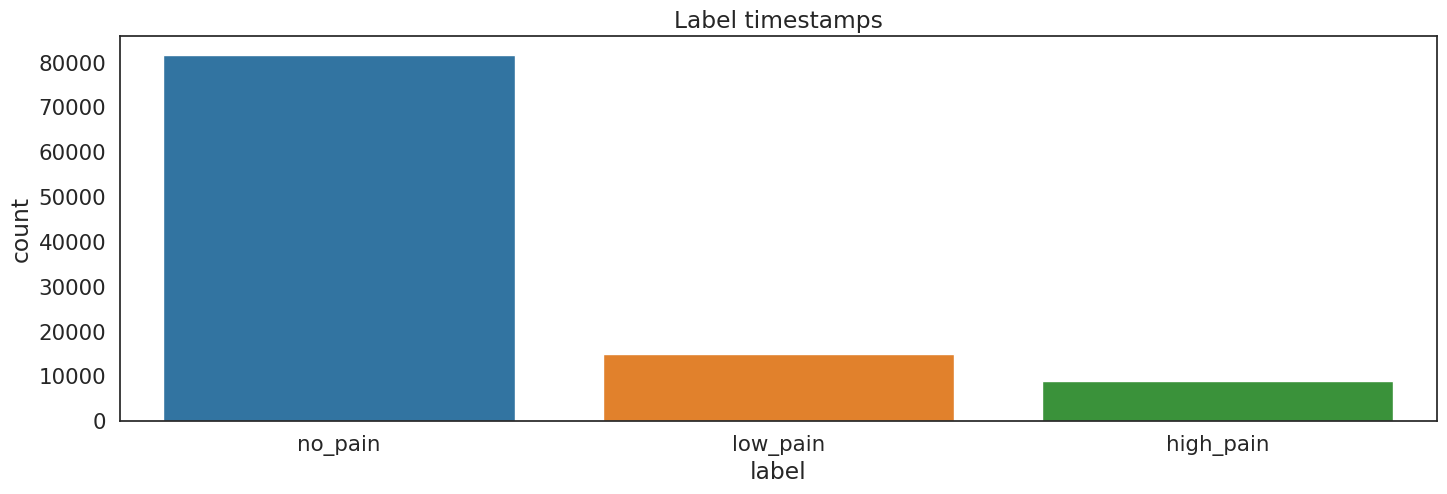

In [11]:
# Visualise the count of timestamps for each activity
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=df,
    order=df['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Label timestamps')

# Display the plot
plt.show()

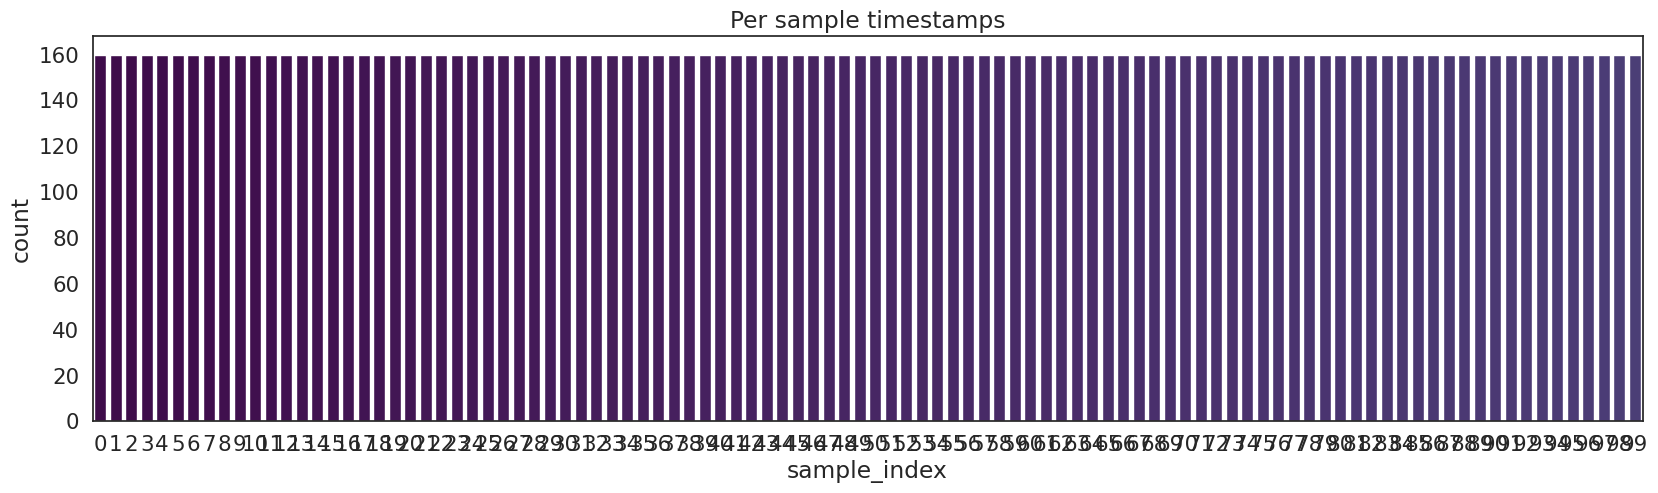

In [12]:
# Count the number of unique samples
n_samples = len(df['sample_index'].unique())

# Create a custom colour map with distinct colours for each sample
colors = plt.cm.viridis(np.linspace(0, 1, n_samples))

# Visualise the count of timestamps for each sample (limit for first 100 samples)
plt.figure(figsize=(20, 5))
sns.countplot(
    x='sample_index',
    data=df[:16000],
    palette=colors
)

# Set the title of the plot
plt.title('Per sample timestamps')

# Display the plot
plt.show()

In [13]:
# Define a function to inspect data for a specific label
def inspect_activity(label, df):
    # Filter the DataFrame for the specified label and limit to 1000 rows
    data = df[df['label'] == label][['time'] + model_columns][:16000]
    data = data.reset_index(drop=True)

    # Plot the data for each axis
    axis = data.plot(subplots=True, figsize=(20, 20), title=label)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')

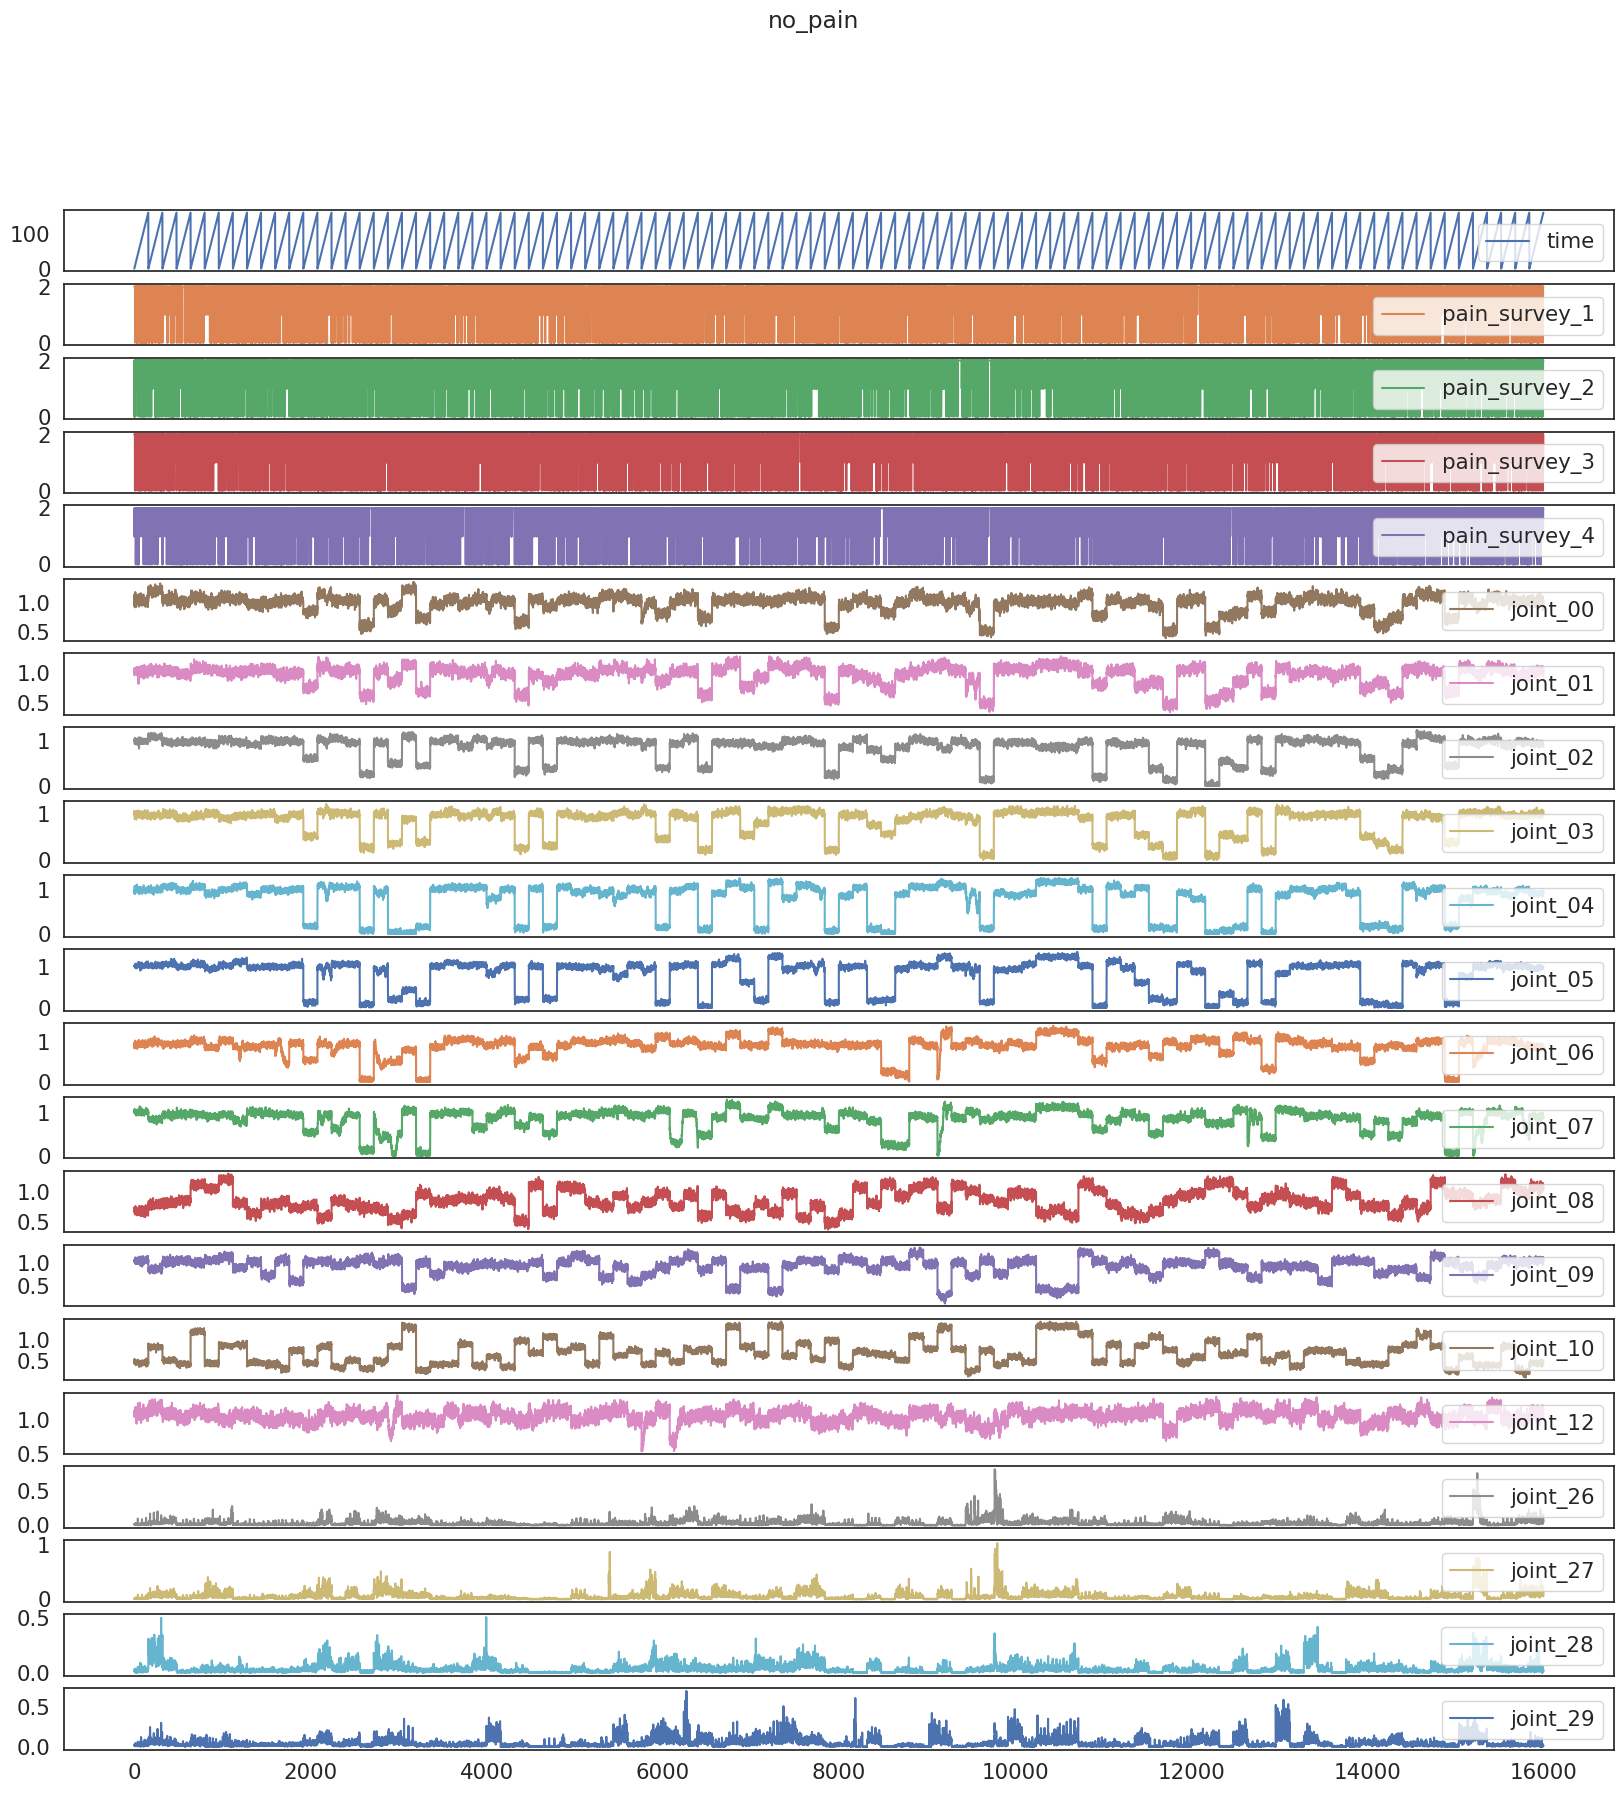

In [14]:
# Inspect the data for the label 'no_pain'
inspect_activity('no_pain', df)

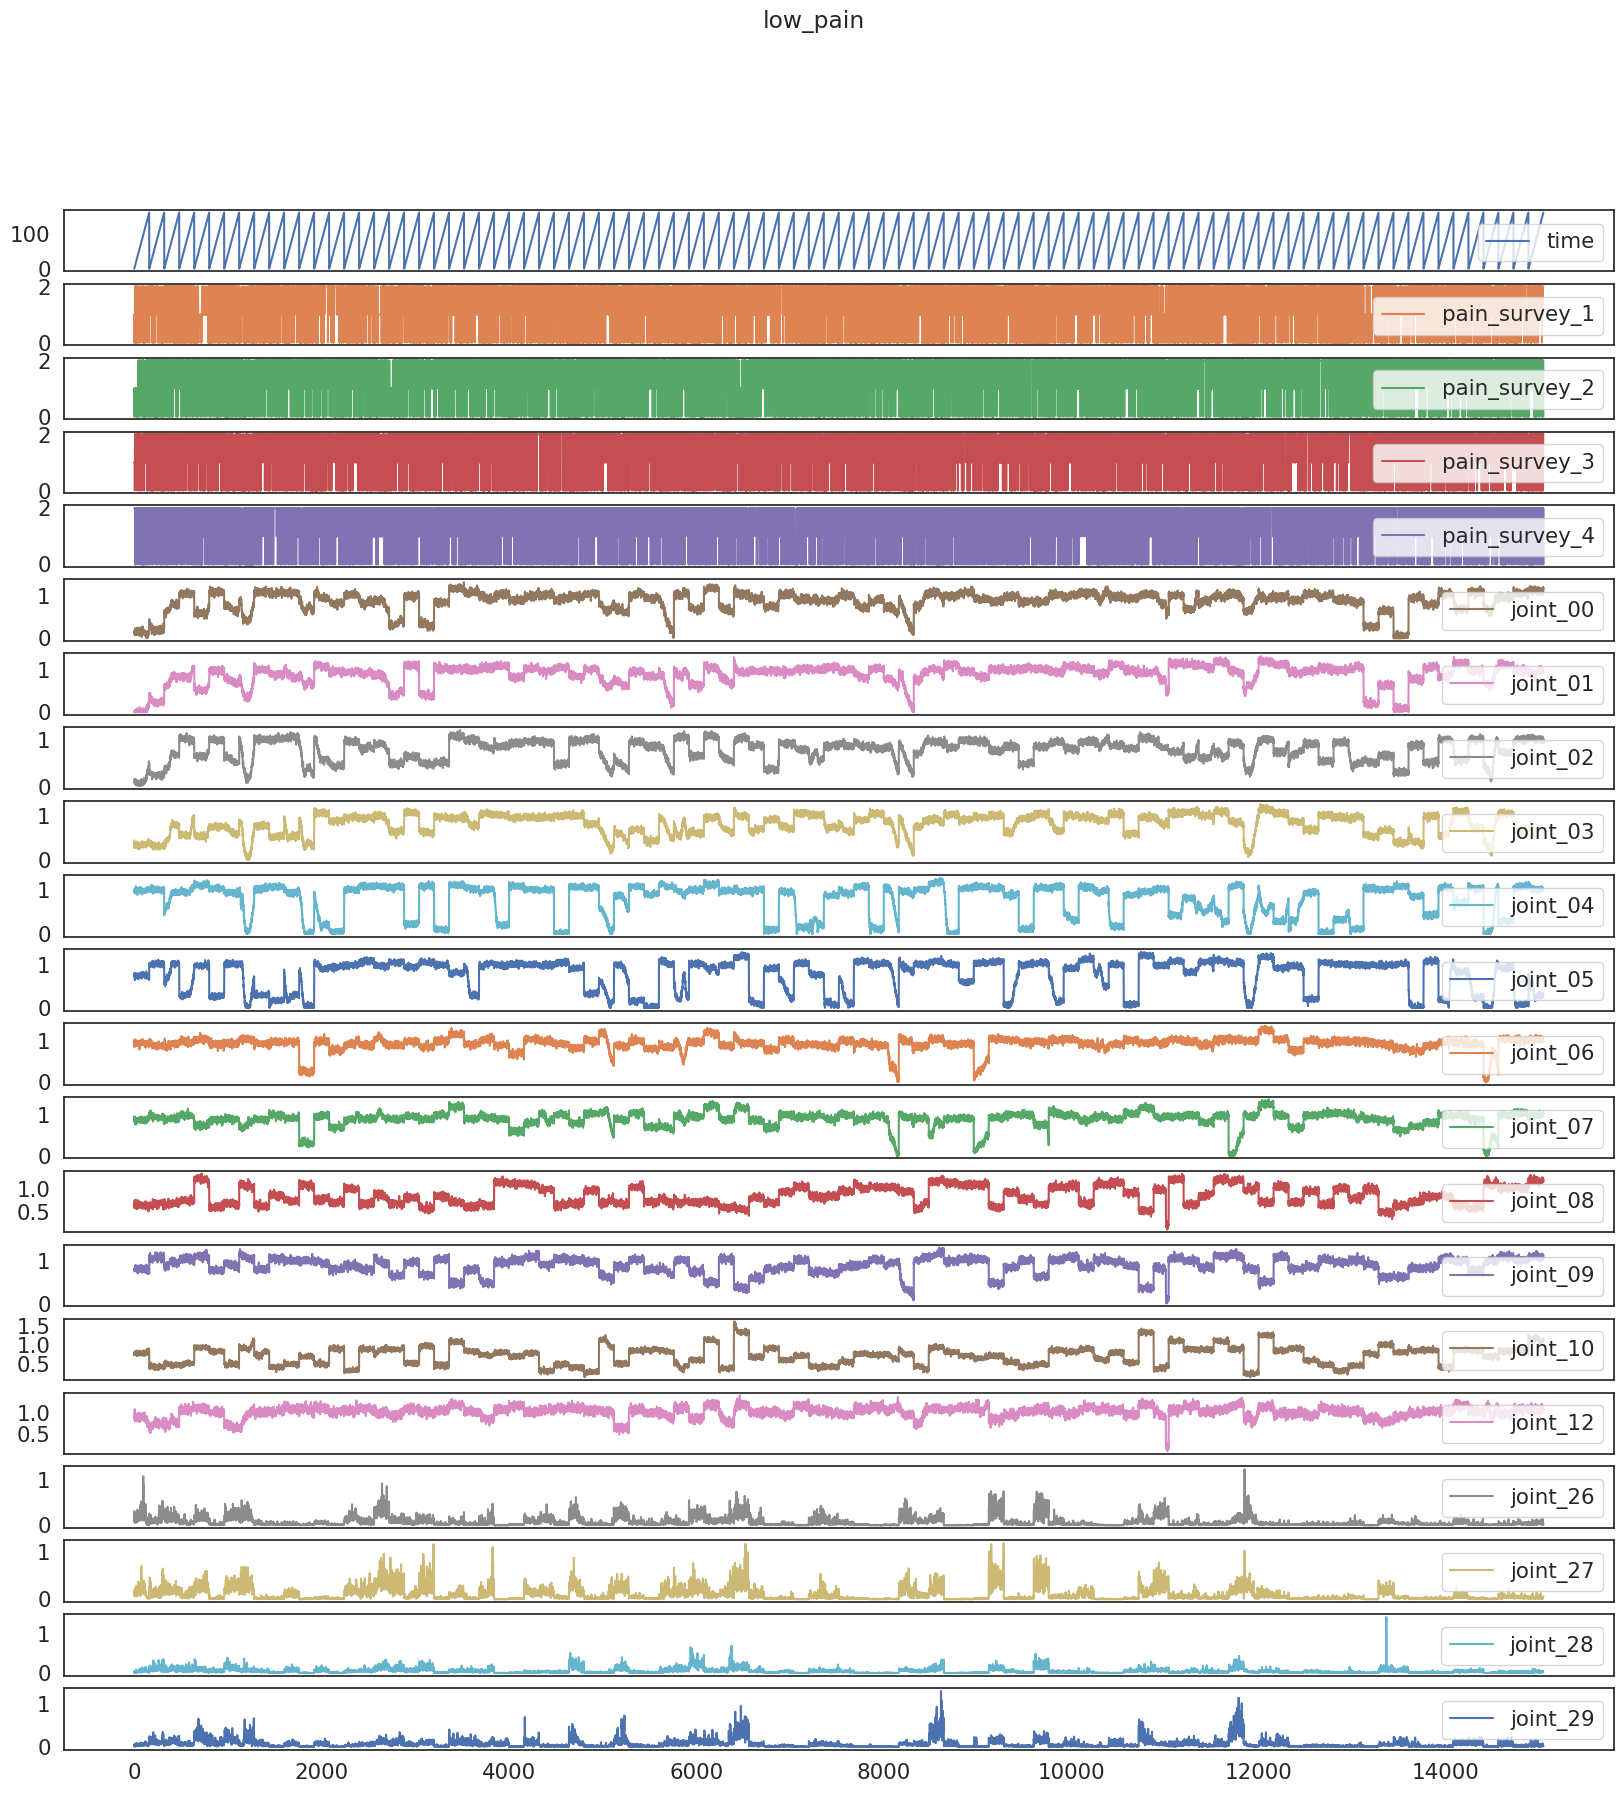

In [15]:
# Inspect the data for the label 'low_pain'
inspect_activity('low_pain', df)

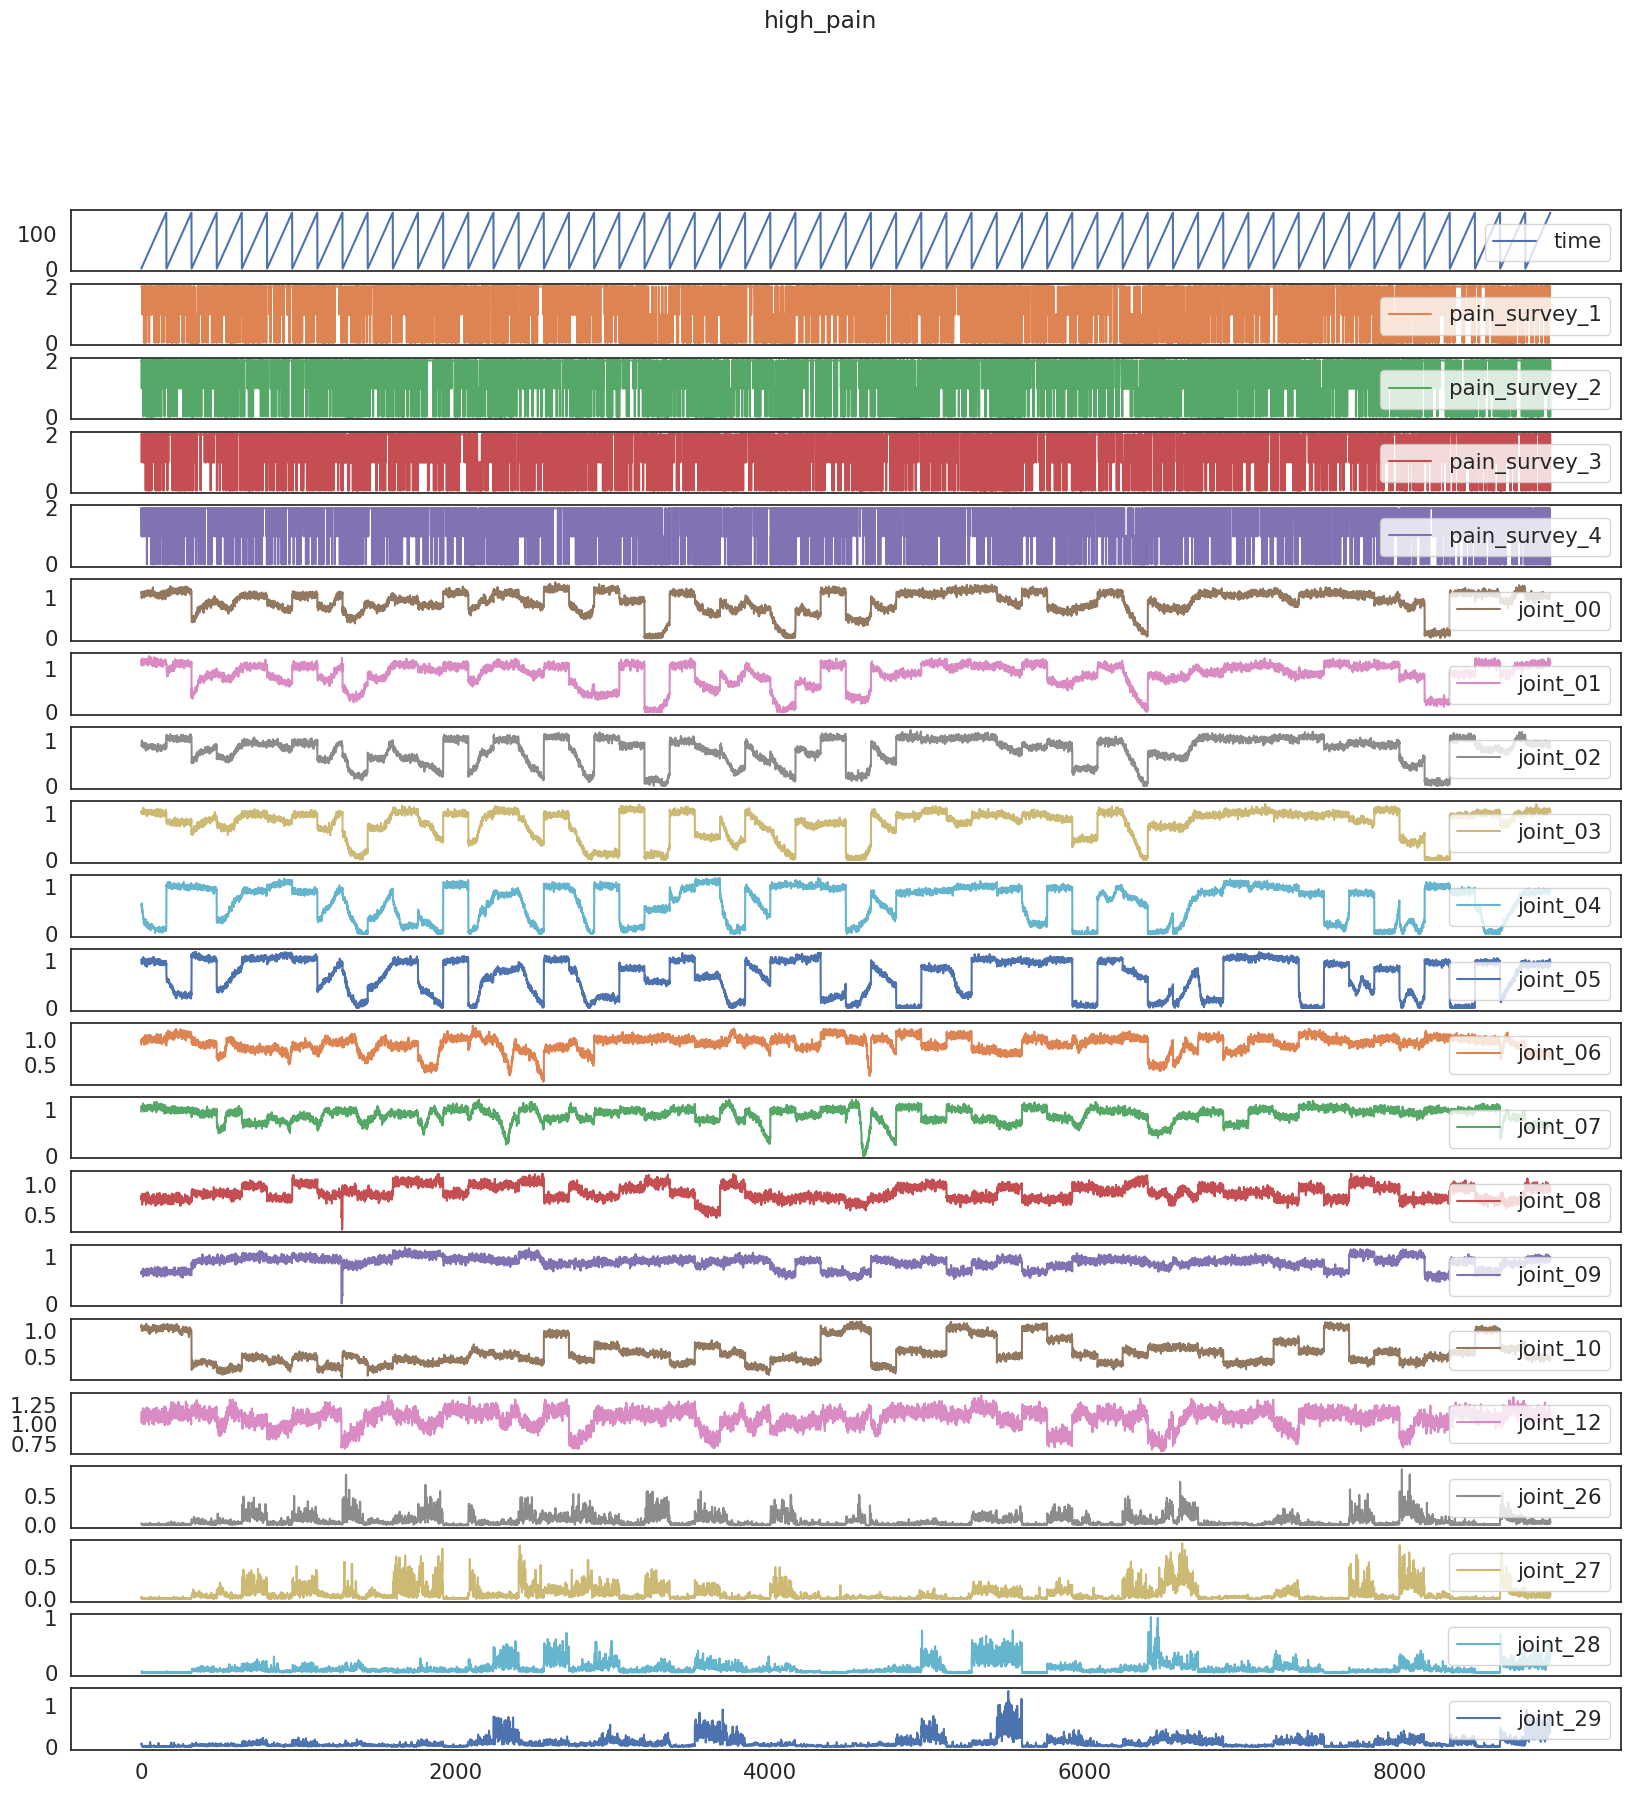

In [16]:
# Inspect the data for the label 'high_pain'
inspect_activity('high_pain', df)

## 🔄 **Data Preprocessing**

In [17]:
# Get unique samples and shuffle them
unique_samples = df['sample_index'].unique()
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_samples)

# Calculate the number of samples for the training set
n_train_users = len(unique_samples) - N_VAL_USERS

# Split the shuffled samples into training and validation sets
train_users = unique_samples[:n_train_users]
val_users = unique_samples[n_train_users:]

# Split the dataset into training and validation sets
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

# Print the shapes of the training and validation sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Training set shape: (84640, 24)
Validation set shape: (21120, 24)


In [18]:
# Initialise a dictionary to count occurrences of each label in the training set
train_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each label for unique sample IDs in the training set
for id in df_train['sample_index'].unique():
    label = df_train[df_train['sample_index'] == id]['label'].values[0]
    train_labels[label] += 1

# Print the distribution of training labels
print('Training labels:', train_labels)

Training labels: {'no_pain': 409, 'low_pain': 75, 'high_pain': 45}


In [19]:
# Compute classes weights
counts = torch.tensor([train_labels['no_pain'],
                       train_labels['low_pain'],
                       train_labels['high_pain']], dtype=torch.float32)

# Inverse frequency weighting and log-smoothing
class_weights = torch.log(1.0 / counts + 1.0)

# Normalize weights
class_weights = class_weights / class_weights.sum()

# Move to device
class_weights = class_weights.to(device)

print("Class weights:", class_weights)

Class weights: tensor([0.0648, 0.3516, 0.5835], device='cuda:0')


In [20]:
# Initialise a dictionary to count occurrences of each label in the validation set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each label for unique sample IDs in the validation set
for id in df_val['sample_index'].unique():
    label = df_val[df_val['sample_index'] == id]['label'].values[0]
    val_labels[label] += 1

# Print the distribution of validation labels
print('Validation labels:', val_labels)

Validation labels: {'no_pain': 102, 'low_pain': 19, 'high_pain': 11}


In [21]:
# Define a mapping of label names to integers
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map label names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

In [22]:
"""
Global min-max scaling
"""
# Define the columns to be normalised
scale_columns = [c for c in model_columns]

# Compute training maxs and mins
train_maxs = df_train[scale_columns].max()
train_mins = df_train[scale_columns].min()

# Normalize by min-max scaling
for col in scale_columns:
    df_train[col] = (df_train[col] - train_mins[col]) / (train_maxs[col] - train_mins[col])
    df_val[col]   = (df_val[col]   - train_mins[col]) / (train_maxs[col] - train_mins[col])
    X_test[col]   = (X_test[col]   - train_mins[col]) / (train_maxs[col] - train_mins[col])

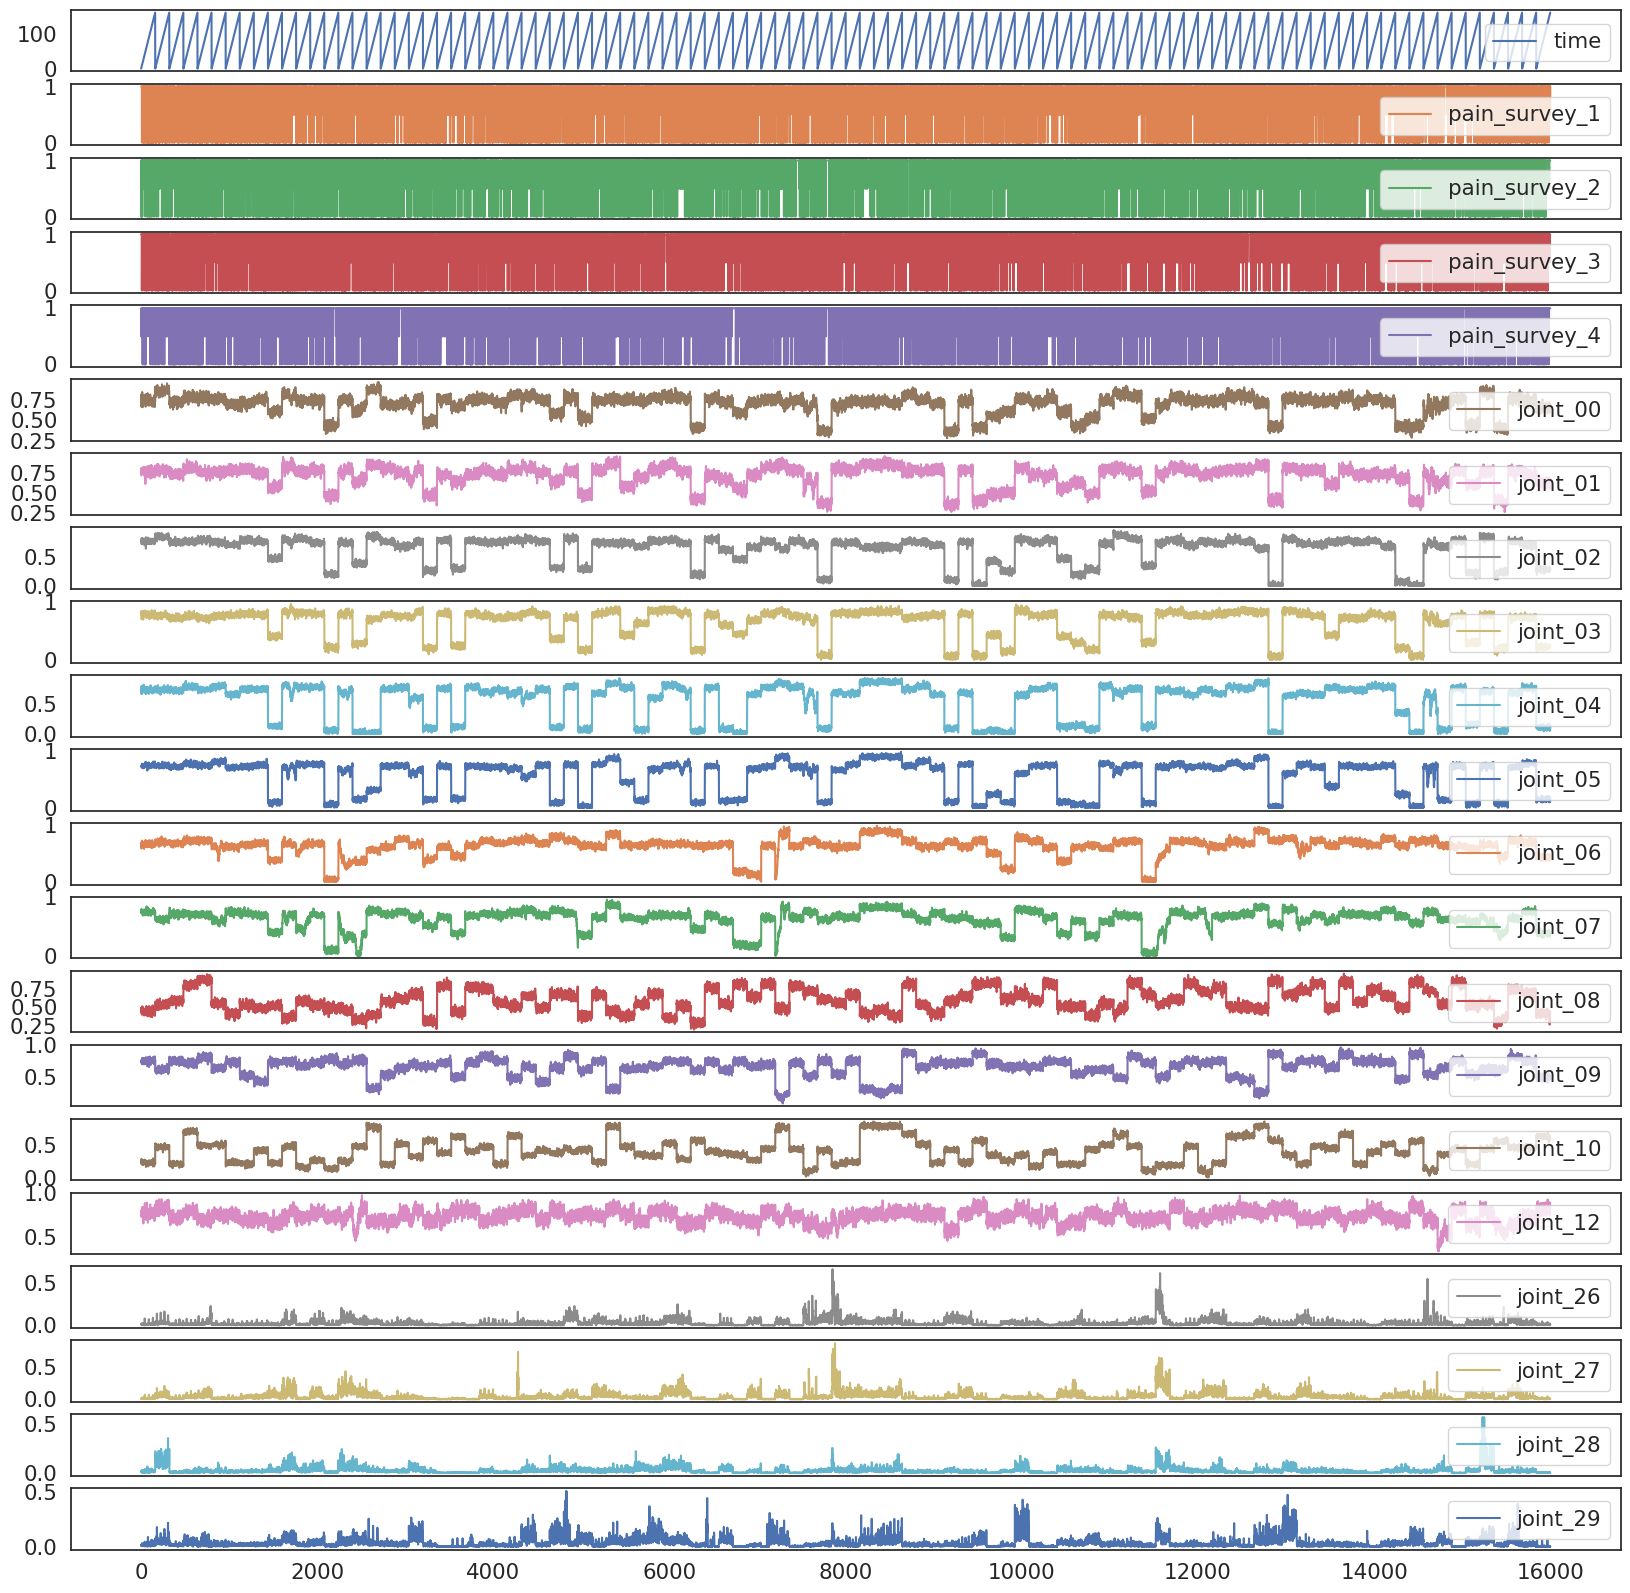

In [23]:
# Inspect the normalized training data for the label 'no_pain'
inspect_activity(0, df_train)

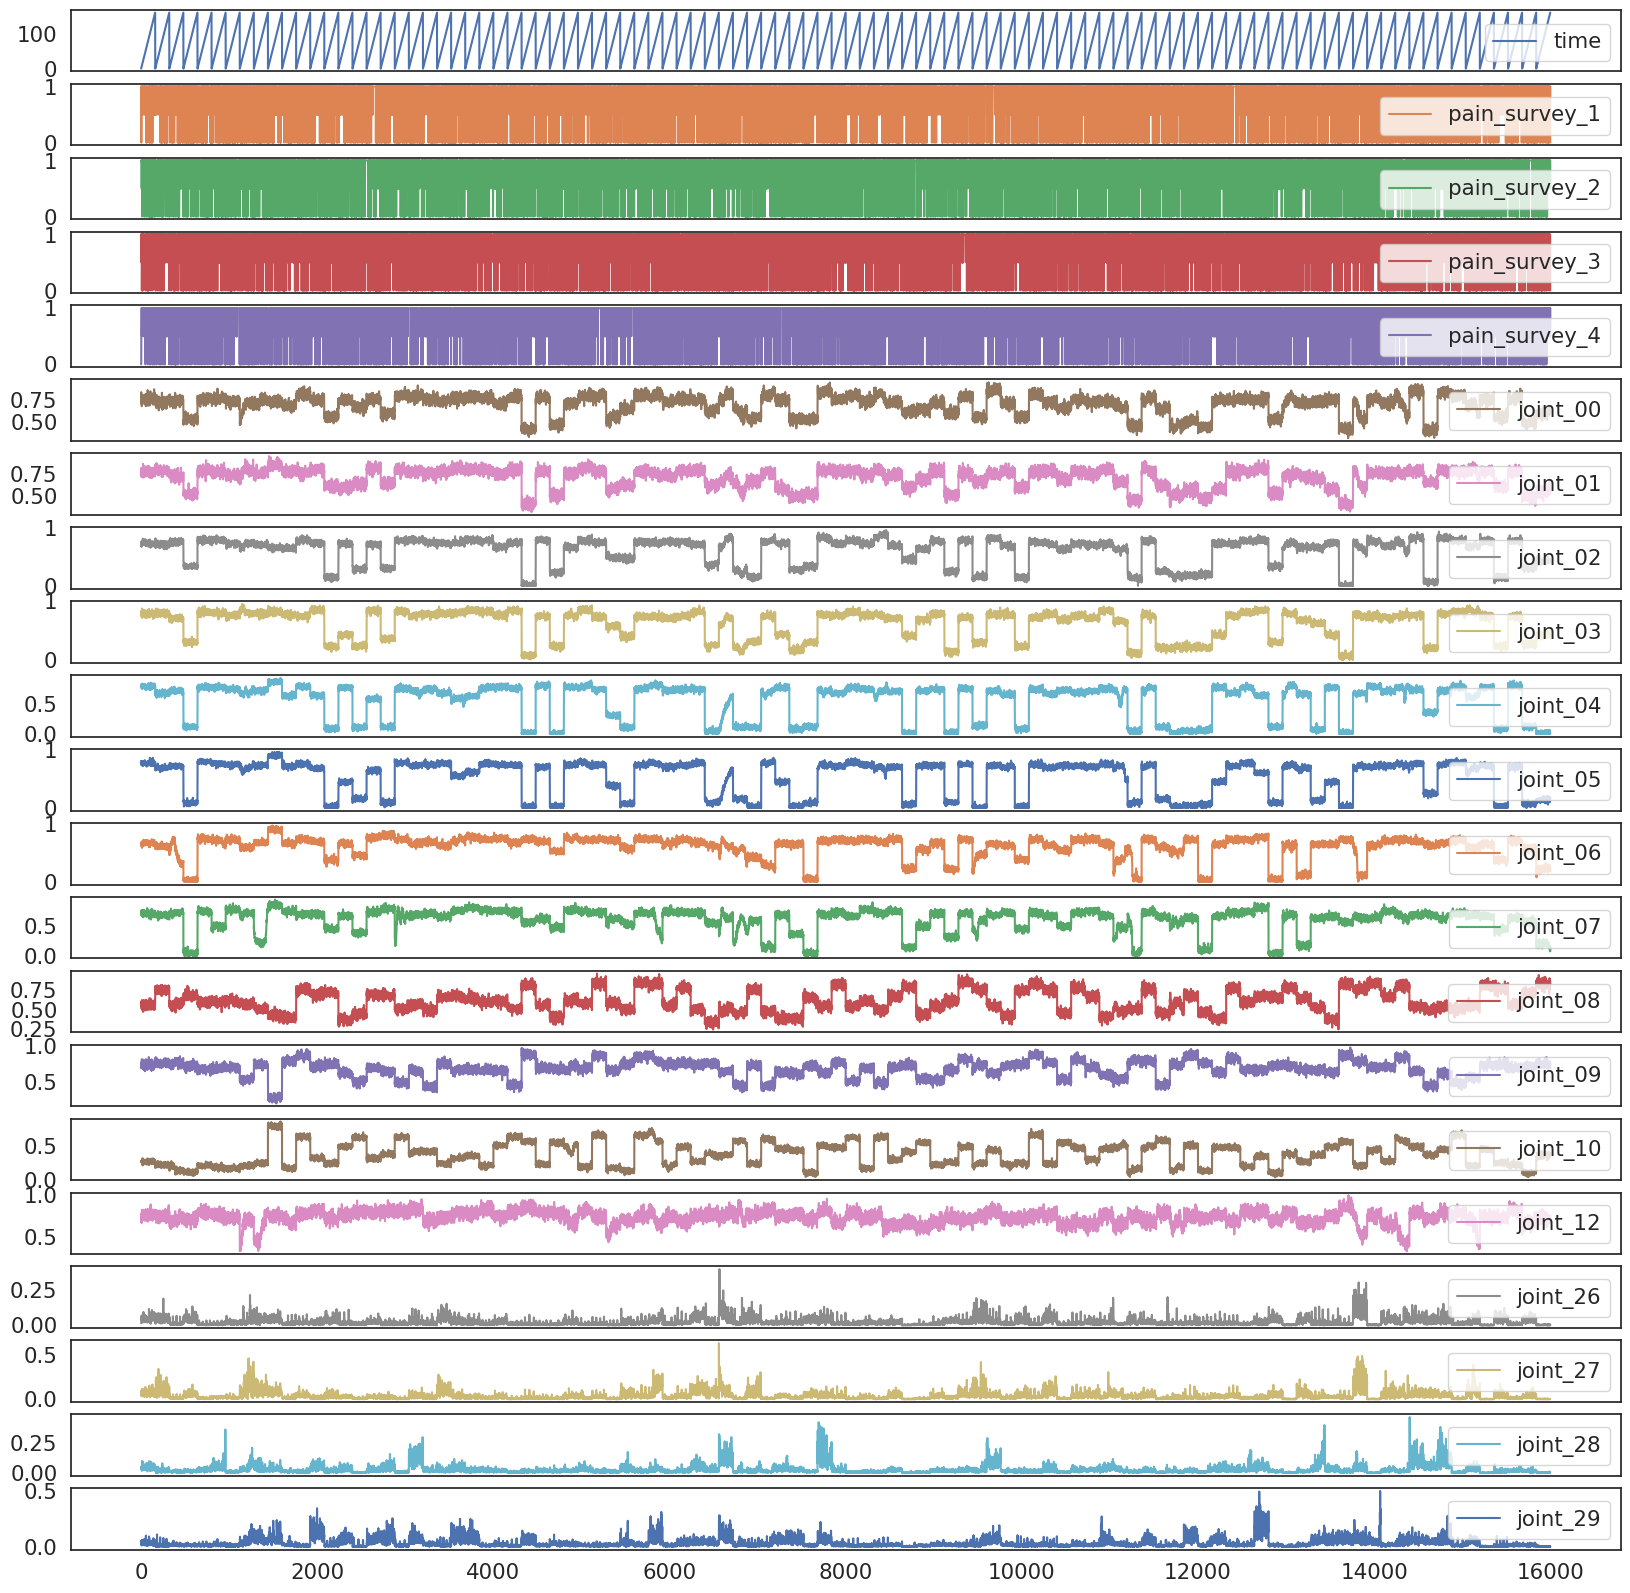

In [24]:
# Inspect the normalized validation data for the label 'no_pain'
inspect_activity(0, df_val)

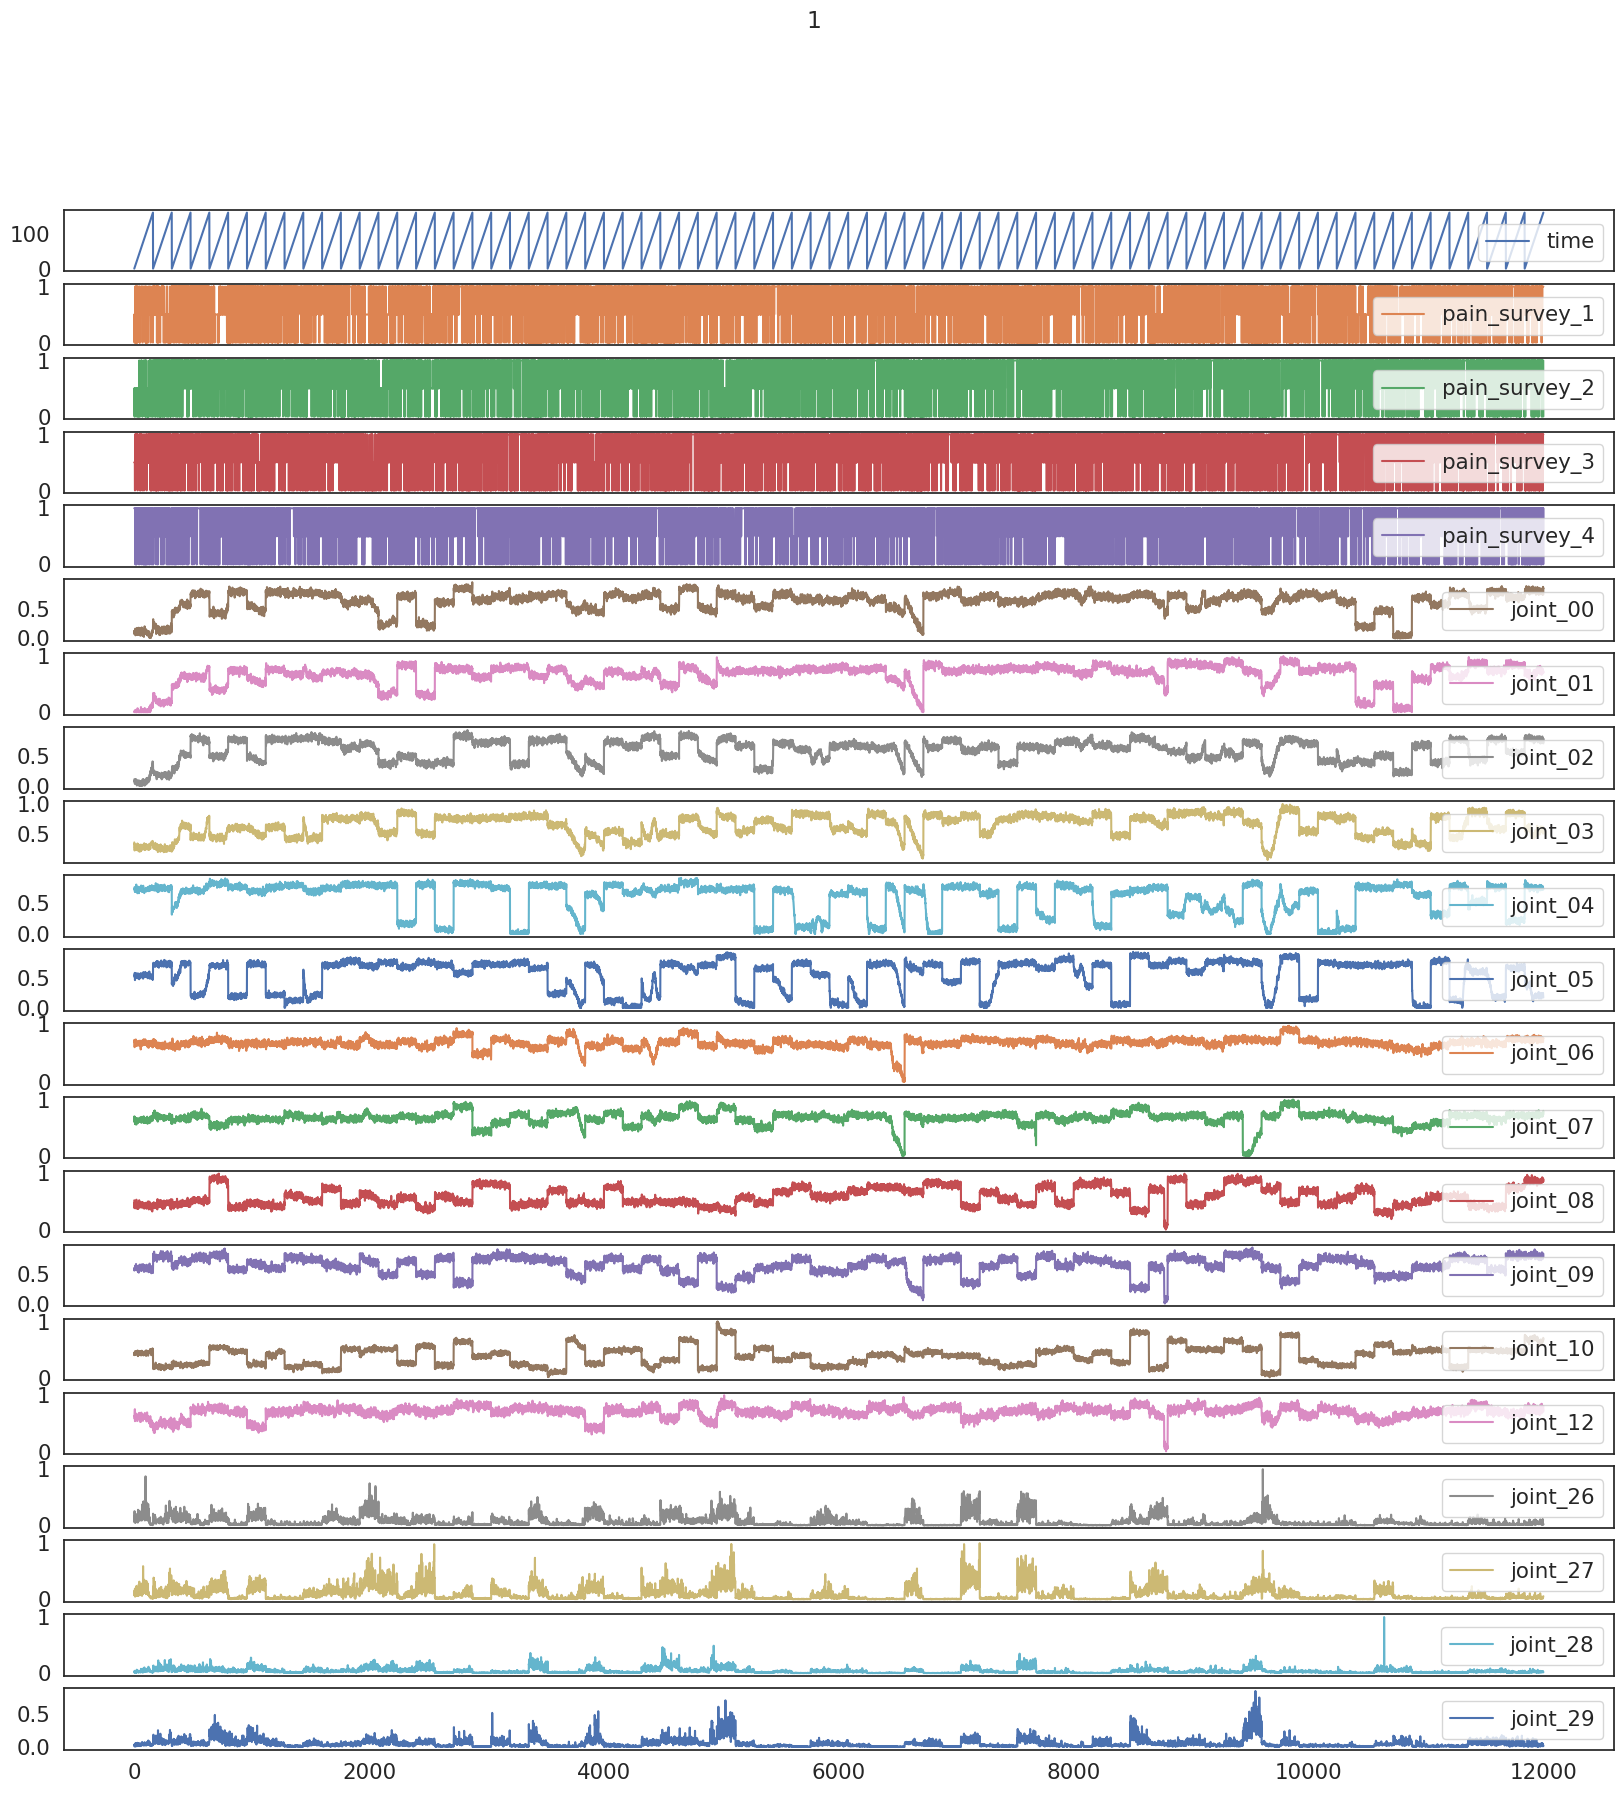

In [25]:
# Inspect the normalized training data for the label 'low_pain'
inspect_activity(1, df_train)

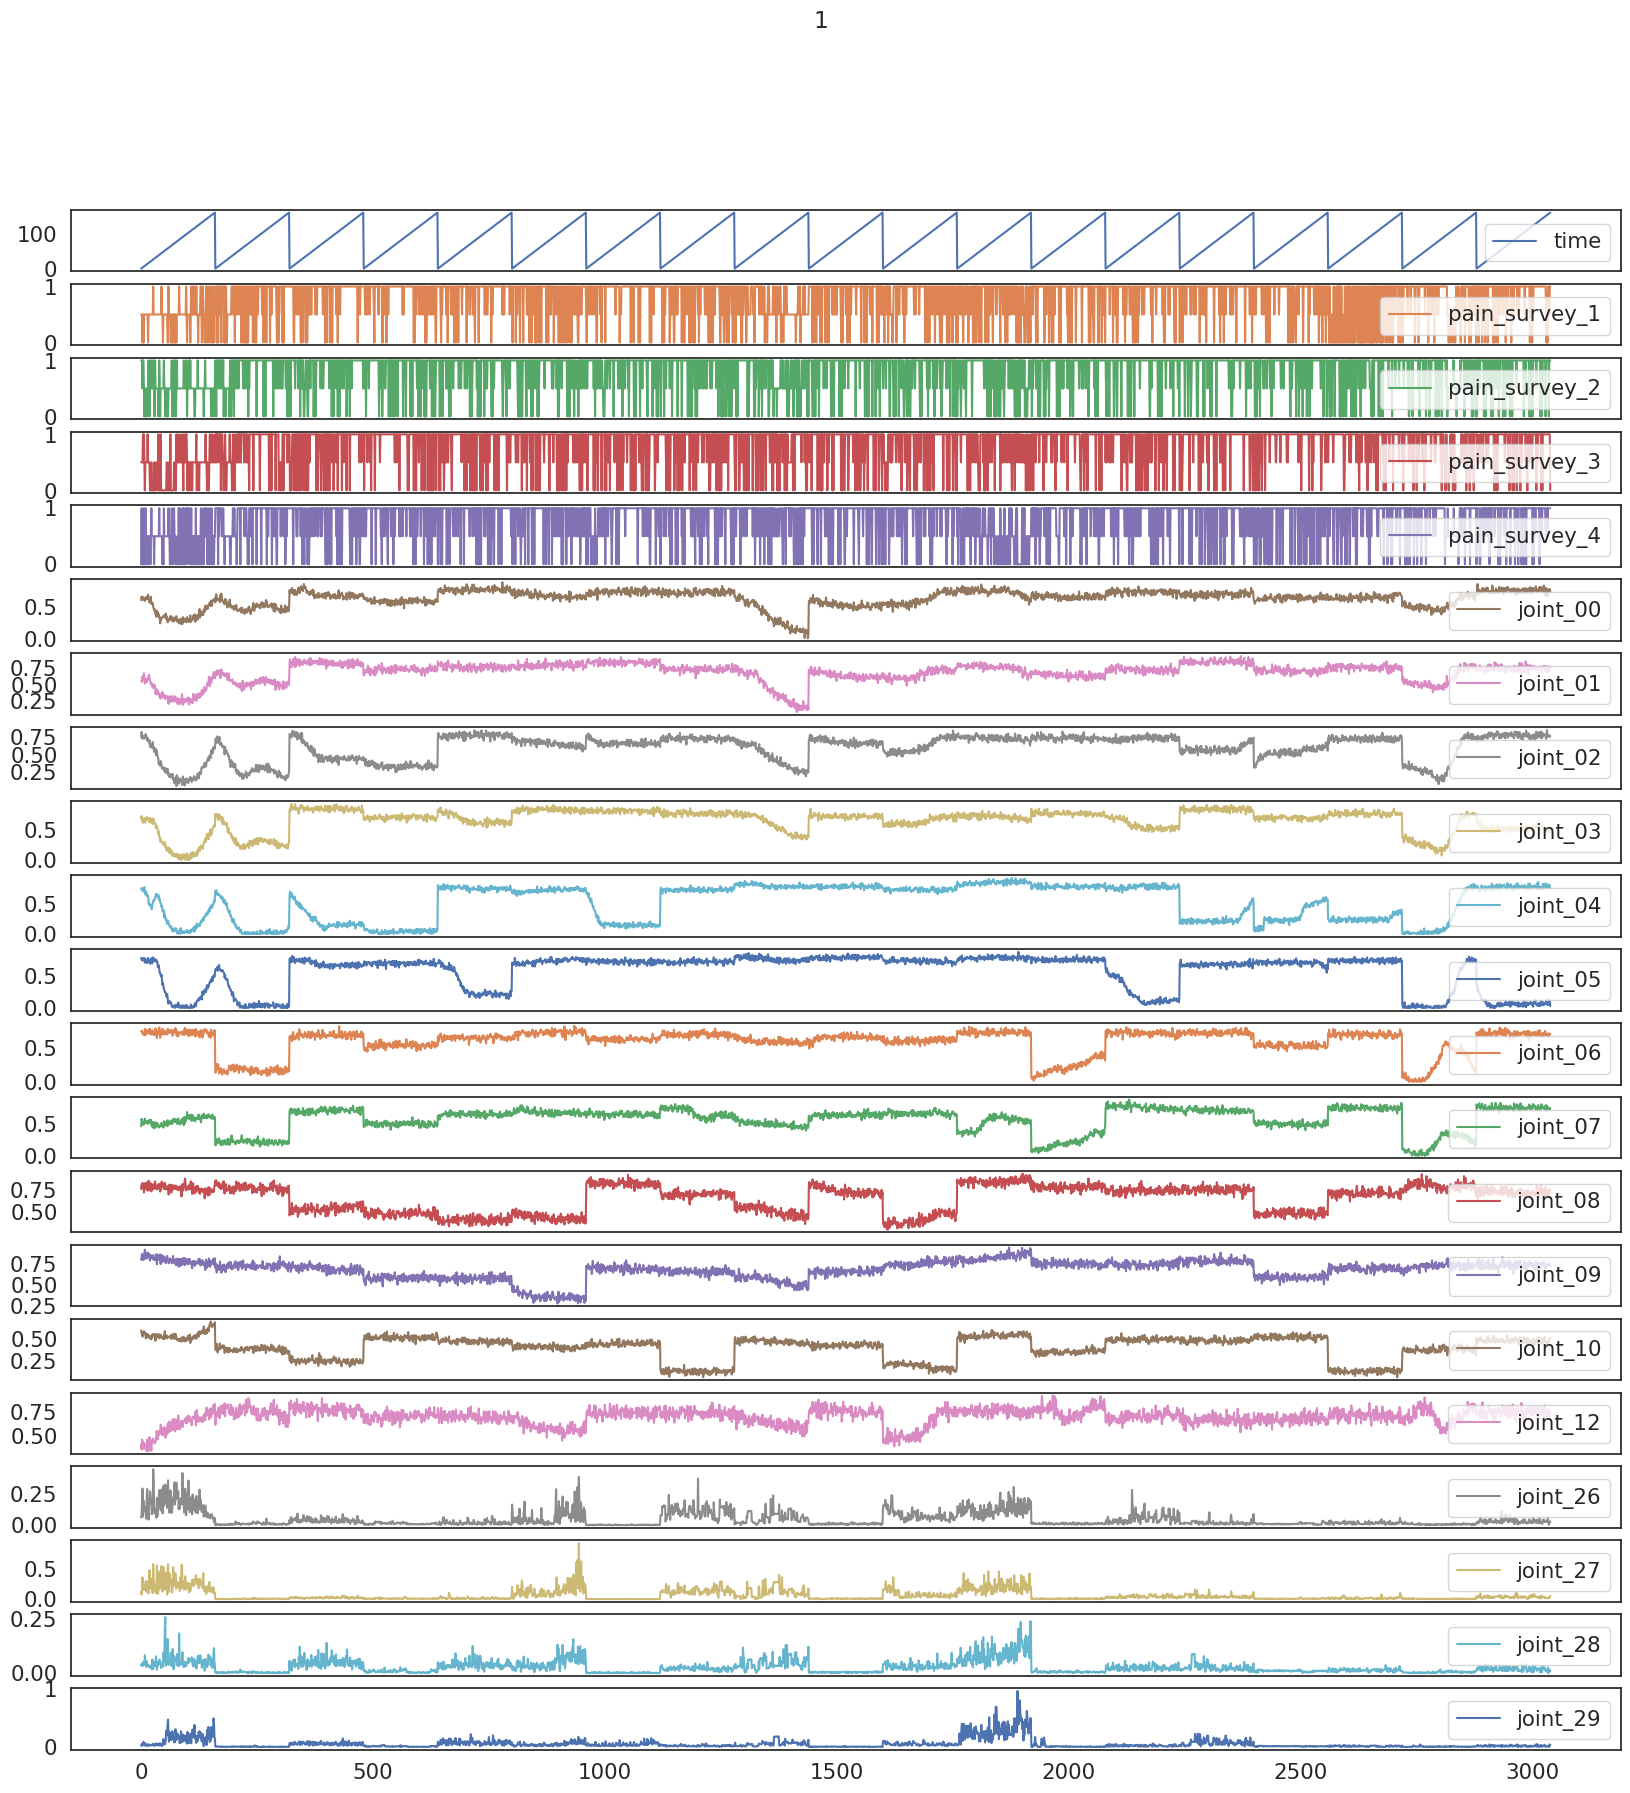

In [26]:
# Inspect the normalized validation data for the label 'low_pain'
inspect_activity(1, df_val)

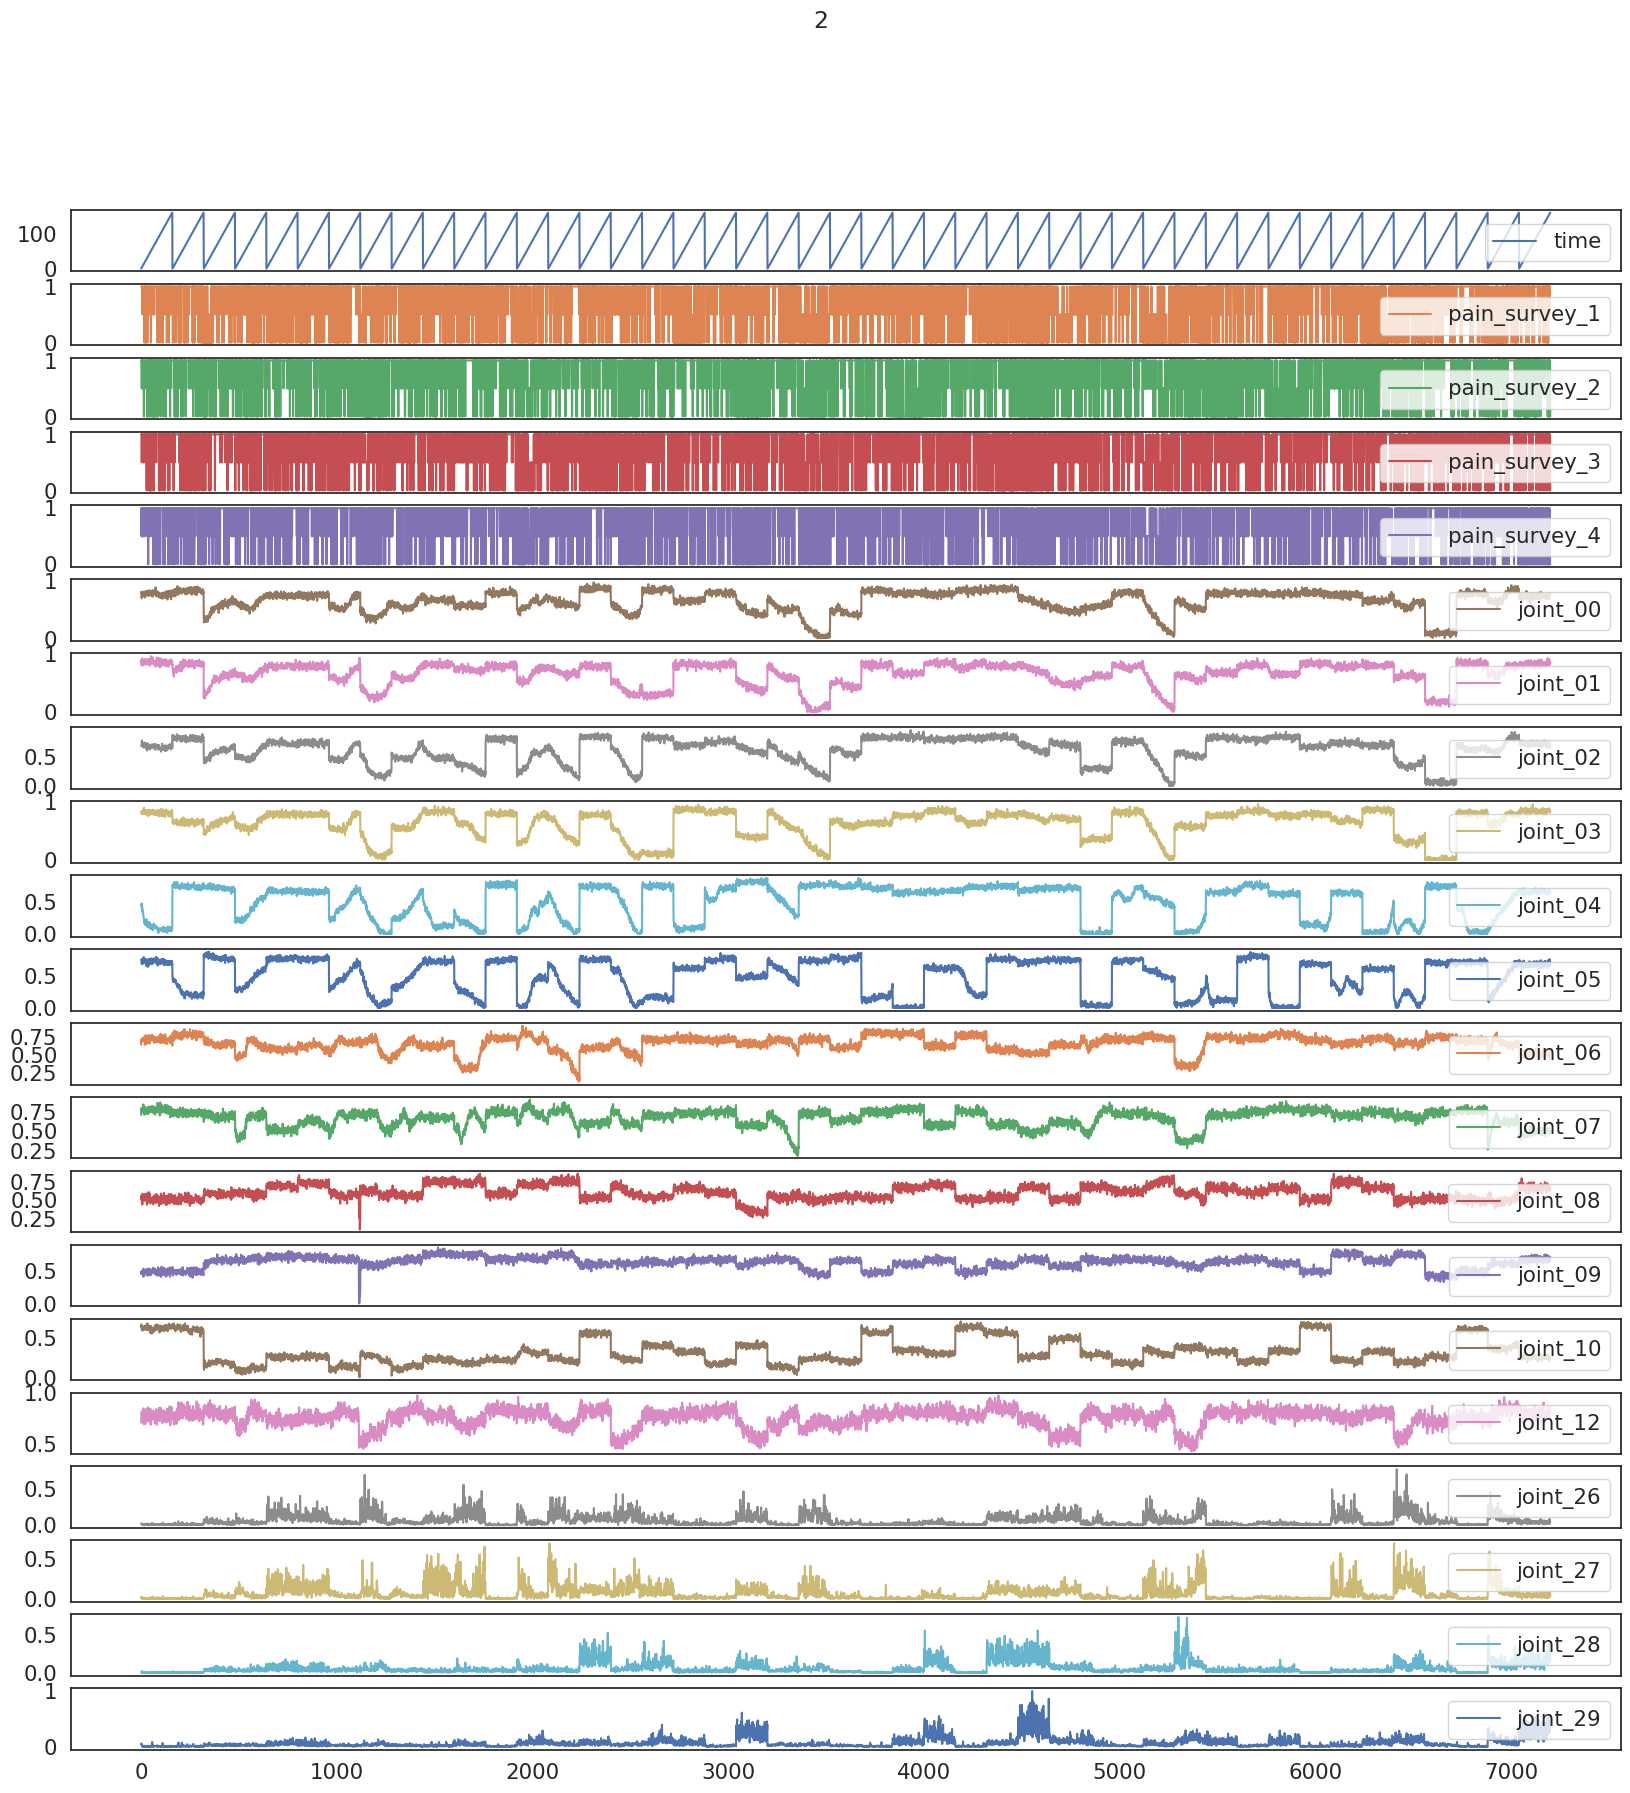

In [27]:
# Inspect the normalized training data for the label 'high_pain'
inspect_activity(2, df_train)

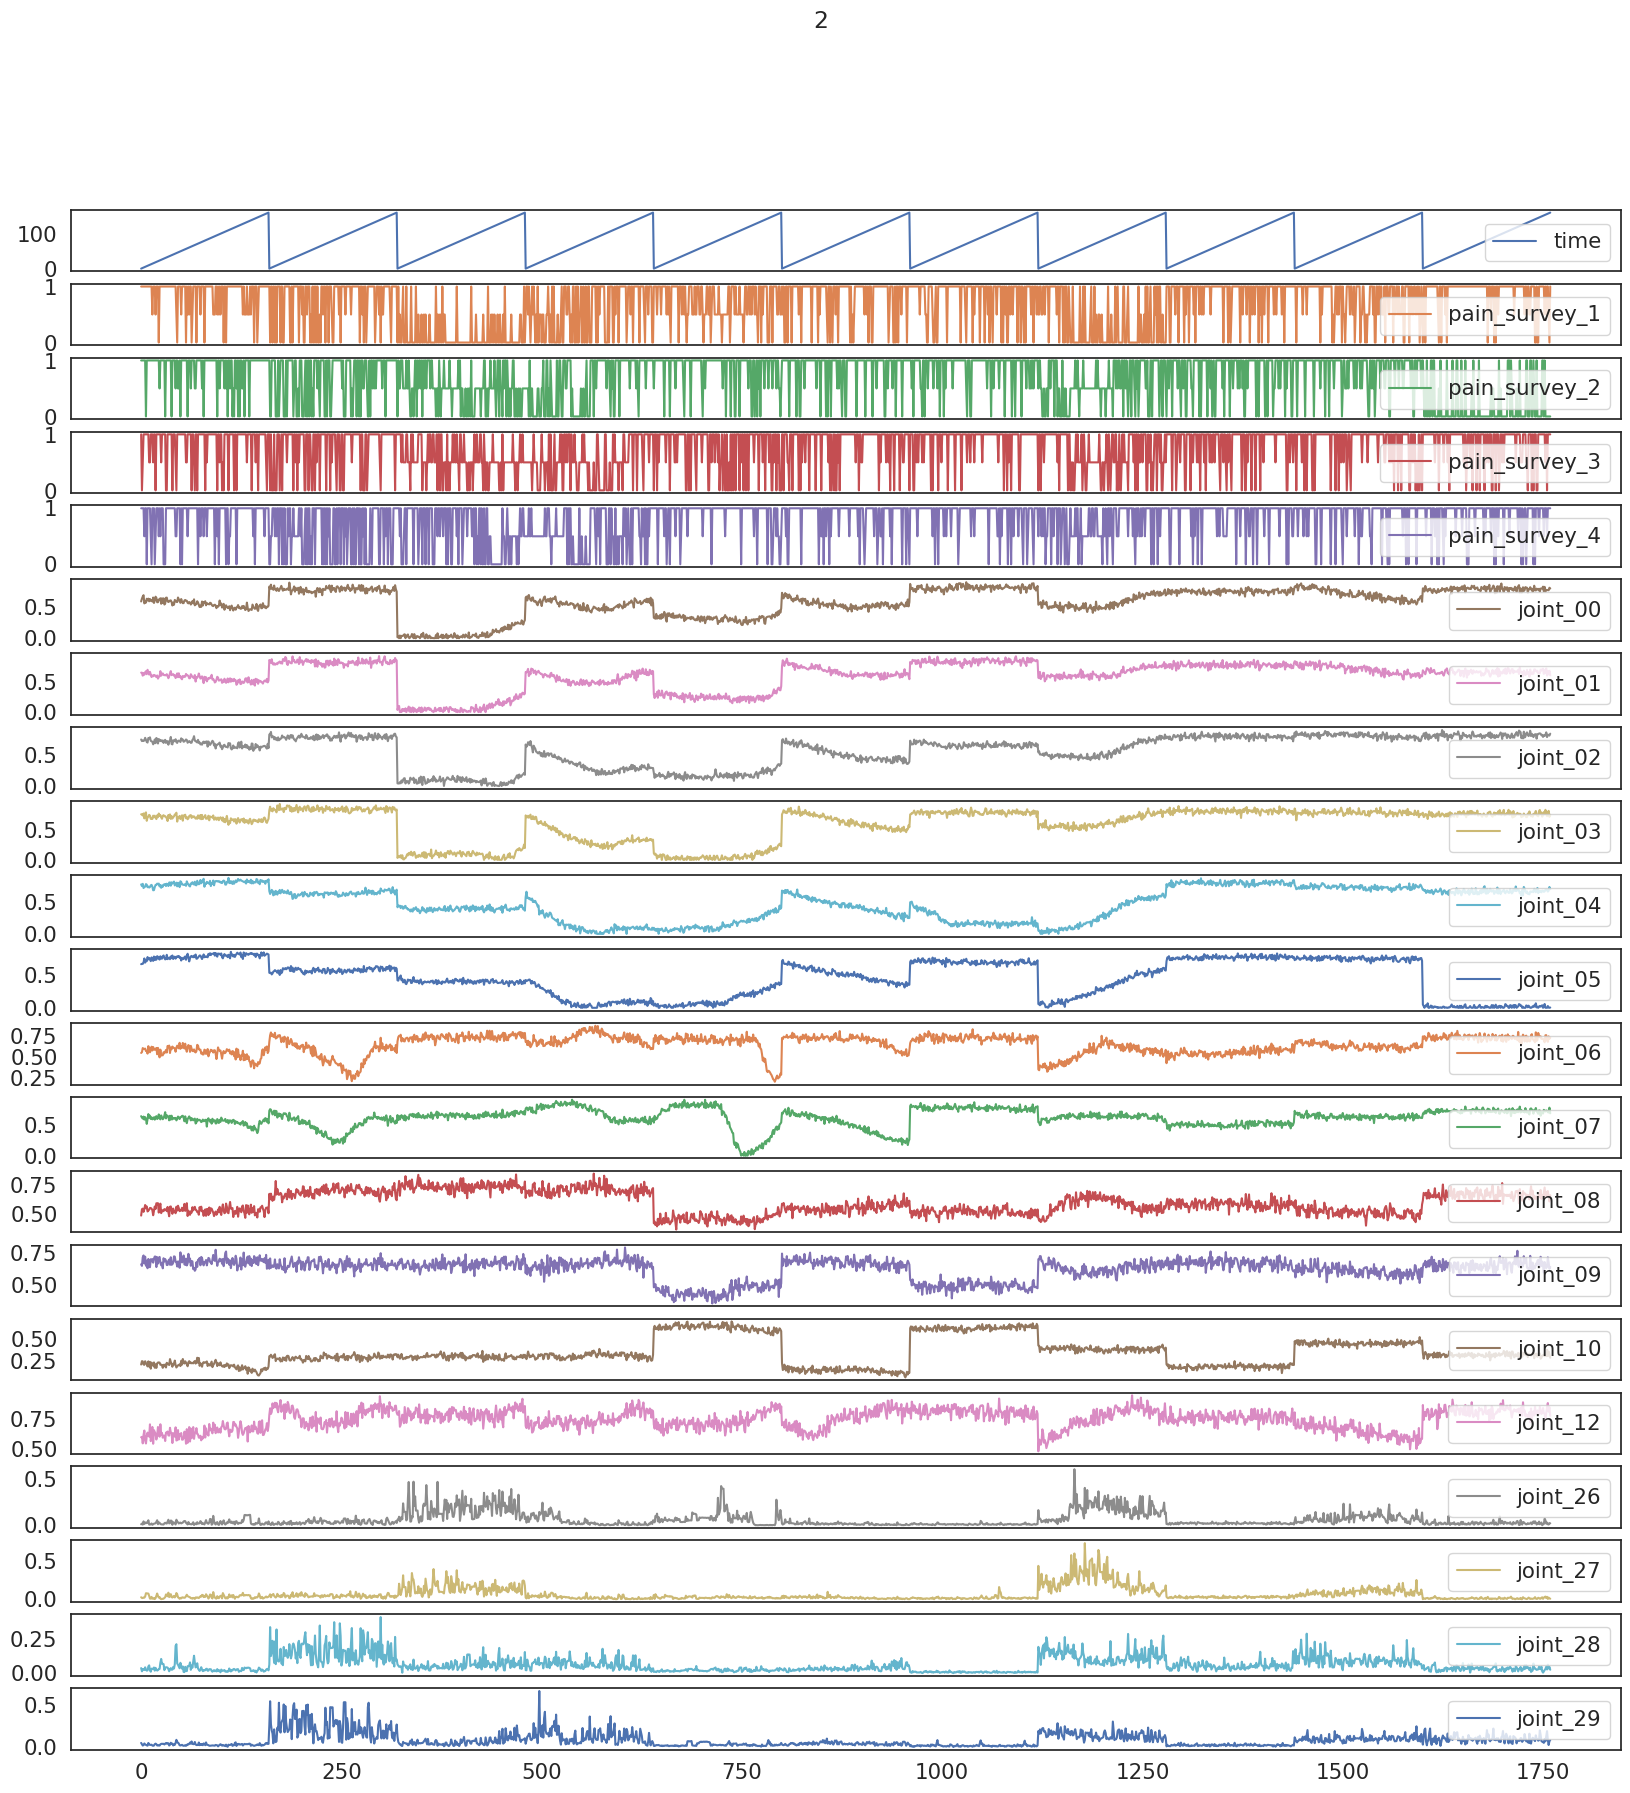

In [28]:
# Inspect the normalized validation data for the label 'high_pain'
inspect_activity(2, df_val)

In [29]:
# Display the first five rows of the training DataFrame
print(df_train.shape)
df_train.head()

(84640, 24)


sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0            1.0            0.0            1.0   
1             0     1            1.0            1.0            1.0   
2             0     2            1.0            0.0            1.0   
3             0     3            1.0            1.0            1.0   
4             0     4            1.0            1.0            1.0   

   pain_survey_4  n_eyes  joint_00  joint_01  joint_02  ...  joint_07  \
0            0.5       0  0.777507  0.738252  0.779485  ...  0.733981   
1            1.0       0  0.806256  0.765147  0.761124  ...  0.760554   
2            1.0       0  0.767592  0.721439  0.772806  ...  0.787647   
3            1.0       0  0.666220  0.810416  0.763942  ...  0.793524   
4            1.0       0  0.774297  0.773366  0.772134  ...  0.725437   

   joint_08  joint_09  joint_10  joint_12  joint_26  joint_27  joint_28  \
0  0.478382  0.755707  0.276742  0.762947  0.014211  0.011376  0.018978   
1  0.486231  0.763060  0.222432  0.727910  0.010745  0.000000  0.009473   
2  0.441994  0.727711  0.213039  0.760757  0.013093  0.006830  0.017065   
3  0.469554  0.753597  0.243433  0.767434  0.009502  0.006274  0.020264   
4  0.477740  0.751796  0.226434  0.772967  0.004212  0.002132  0.023389   

   joint_29  label  
0  0.020291      0  
1  0.010006      0  
2  0.016856      0  
3  0.017981      0  
4  0.018477      0  

[5 rows x 24 columns]

In [30]:
# Define a function to build sequences from the dataset
def build_sequences(df, window, stride):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    time_idx_list = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][model_columns].values

        # Extract raw time indices (0..159)
        t_idx = df[df['sample_index'] == id]['time'].values

        # Retrieve the activity label for the current ID
        label = df[df['sample_index'] == id]['label'].values[0]

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            time_idx_list.append(t_idx[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    time_idx_list = np.array(time_idx_list)
    labels = np.array(labels)

    return dataset, time_idx_list, labels

In [31]:
# Define a function to build sequences for the test set
def build_sequences_test(df, window, stride):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences
    dataset = []
    time_idx_list = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][model_columns].values

        # Extract raw time indices (0..159)
        t_idx = df[df['sample_index'] == id]['time'].values

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            time_idx_list.append(t_idx[idx:idx + window])
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    time_idx_list = np.array(time_idx_list)

    return dataset, time_idx_list

In [32]:
# Generate sequences and labels for the training set
X_s_train, T_s_train, y_s_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_s_val, T_s_val, y_s_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences for the test set
X_s_test, T_s_test = build_sequences_test(X_test, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_s_train.shape, y_s_train.shape, X_s_val.shape, y_s_val.shape, X_s_test.shape

((19573, 16, 20), (19573,), (4884, 16, 20), (4884,), (48988, 16, 20))

In [33]:
# Define the input shape based on the training data
input_shape = X_s_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_s_train))

In [34]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_s_train), torch.from_numpy(T_s_train), torch.from_numpy(y_s_train))
val_ds   = TensorDataset(torch.from_numpy(X_s_val),   torch.from_numpy(T_s_val),   torch.from_numpy(y_s_val))
test_ds  = TensorDataset(torch.from_numpy(X_s_test),  torch.from_numpy(T_s_test))

In [35]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=torch.Generator().manual_seed(SEED),
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [36]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = make_loader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [37]:
# Get one batch from the training data loader
for xb, _, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([512, 16, 20])
Labels batch shape: torch.Size([512])


## 🛠️ **Model Building**

In [38]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    # input_size = (seq_len, features)
    seq_len, feat_dim = input_size
    dummy_input = torch.randn(1, seq_len, feat_dim).to(device)

    # dummy time indices: just zeros from 0..159 (within embedding range)
    dummy_t_idx = torch.zeros(1, seq_len, dtype=torch.long, device=device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input, dummy_t_idx)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [39]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='RNN',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        # --- Time embedding ---
        # time indices are 0..159, embed them into a small 8-dim space
        self.time_emb_dim = 8
        self.time_emb = nn.Embedding(num_embeddings=160, embedding_dim=self.time_emb_dim)

        # --- 1D convolution over time ---
        input_size = input_size + self.time_emb_dim

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x, t_idx):
        """
        x shape: (batch_size, seq_length, input_size)
        t_idx: (batch_size, seq_length)             - integer time indices [0..159]
        """
        # --- Time embedding ---
        # (B, T) -> (B, T, time_emb_dim)
        t_emb = self.time_emb(t_idx)          # (B, T, 8)

        # concat along feature dimension
        x = torch.cat([x, t_emb], dim=-1)     # (B, T, input_size + 8)

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

In [40]:
def CNN_recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    # input_size = (seq_len, features)
    seq_len, feat_dim = input_size
    dummy_input = torch.randn(1, seq_len, feat_dim).to(device)

    # dummy time indices: just zeros from 0..159 (within embedding range)
    dummy_t_idx = torch.zeros(1, seq_len, dtype=torch.long, device=device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if name == "conv_layers":
            # Handle CNN layers inside conv_layers
            for i, block in enumerate(module):
                block_name = f"conv_block_{i}"
                for sub in block:
                    if isinstance(sub, nn.Conv1d):
                        h = sub.register_forward_hook(get_hook(block_name))
                        hooks.append(h)
            continue
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input, dummy_t_idx)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Print CNN blocks
    for i, block in enumerate(model.conv_layers):
        block_name = f"conv_block_{i}"
        if block_name in output_shapes:
            params = sum(p.numel() for p in block.parameters())
            train_params = sum(p.numel() for p in block.parameters() if p.requires_grad)

            total_params += params
            total_trainable_params += train_params

            print(f"{block_name:<25} {output_shapes[block_name]:<28} {train_params:,}")

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name == "conv_layers":
            continue
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [41]:
class CNN_RecurrentClassifier(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            conv_channels,
            kernel_sizes,
            pool_sizes,
            cnn_stride,
            cnn_dropout_rate,
            rnn_type='RNN',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super(CNN_RecurrentClassifier, self).__init__()

        # --- Time embedding ---
        # time indices are 0..159, embed them into a small 8-dim space
        self.time_emb_dim = 8
        self.time_emb = nn.Embedding(num_embeddings=160, embedding_dim=self.time_emb_dim)

        # --- 1D convolution over time ---
        input_size = input_size + self.time_emb_dim

        # CNN layer
        self.conv_layers = nn.ModuleList()
        in_ch = input_size

        for out_ch, k_size, pool_size in zip(conv_channels, kernel_sizes, pool_sizes):
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=k_size, stride=cnn_stride, padding=k_size // 2),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=pool_size, stride=pool_size),
                nn.Dropout(cnn_dropout_rate)
            ))
            in_ch = out_ch

        # RNN layer
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=in_ch,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x, t_idx):
        """
        x shape: (batch_size, seq_length, input_size)
        t_idx: (batch_size, seq_length)             - integer time indices [0..159]
        """
        # --- Time embedding ---
        # (B, T) -> (B, T, time_emb_dim)
        t_emb = self.time_emb(t_idx)          # (B, T, 8)

        # concat along feature dimension
        x = torch.cat([x, t_emb], dim=-1)     # (B, T, input_size + 8)

        # CNN takes input of shape (batch_size, channels, seq_len)
        x = x.permute(0, 2, 1)
        for conv in self.conv_layers:
            x = conv(x)

        # RNN takes input of shape (batch_size, seq_len, input_size)
        x = x.permute(0, 2, 1)
        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

In [42]:
class SoftCELoss(nn.Module):
    def __init__(self, eps=0.05, num_classes=3):
        super().__init__()
        self.eps = eps
        self.num_classes = num_classes

    def forward(self, logits, target):
        # One-hot encode
        with torch.no_grad():
            soft = torch.zeros_like(logits).scatter_(1, target.unsqueeze(1), 1.0)

            # apply smoothing ONLY to class 0
            idx0 = target == 0
            soft[idx0] = (1 - self.eps) * soft[idx0] + (self.eps / (self.num_classes - 1))

        logp = torch.log_softmax(logits, dim=1)
        loss = -(soft * logp).sum(dim=1).mean()
        return loss

In [43]:
loss_dict = {
    'CE': nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING),
    'weighted CE': nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING, weight=class_weights),
    'soft CE': SoftCELoss(eps=LABEL_SMOOTHING)
}

# Loss function selection
try:
    criterion = loss_dict[CRITERION]
except KeyError:
    raise ValueError(f"CRITERION '{CRITERION}' not recognized")

## 🧠 **Model Training**

In [44]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, time_idx, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs = inputs.to(device)
        time_idx =  time_idx.to(device)
        targets = targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        if device.type == "cuda":
            with torch.amp.autocast(device_type="cuda", enabled=True):
                logits = model(inputs, time_idx)
                loss = criterion(logits, targets)
        # DirectML / CPU: no autocast
        else:
            logits = model(inputs, time_idx)
            loss = criterion(logits, targets)

        # Regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2).sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward
        if scaler:
            scaler.scale(loss).backward()
            # unscale then clip
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [45]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, time_idx, targets in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            time_idx =  time_idx.to(device)
            targets = targets.to(device)
            # Forward pass with mixed precision (if CUDA available)
            if device.type == "cuda":
                with torch.amp.autocast(device_type="cuda", enabled=True):
                    logits = model(inputs, time_idx)
                    loss = criterion(logits, targets)
            # DirectML / CPU: no autocast
            else:
                logits = model(inputs, time_idx)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [46]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [47]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = ((current_metric > best_metric) if mode == 'max' else (current_metric < best_metric))

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [48]:
# Create model and display architecture with parameter count
if USE_CNN:
    rnn_model = CNN_RecurrentClassifier(
        input_size=input_shape[-1], # Pass the number of features
        hidden_size=HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        num_classes=num_classes,
        conv_channels=CONV_CHANNELS,
        kernel_sizes=KERNEL_SIZES,
        pool_sizes=POOL_SIZES,
        cnn_stride=CNN_STRIDE,
        cnn_dropout_rate=CNN_DROPOUT_RATE,
        dropout_rate=DROPOUT_RATE,
        bidirectional=True,
        rnn_type=RNN_TYPE
        )
    CNN_recurrent_summary(rnn_model, input_size=input_shape)
else:
    rnn_model = RecurrentClassifier(
        input_size=input_shape[-1], # Pass the number of features
        hidden_size=HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        bidirectional=True,
        rnn_type=RNN_TYPE
        )
    recurrent_summary(rnn_model, input_size=input_shape)

# Move model to device
rnn_model = rnn_model.to(device)

# Set up TensorBoard logging and save model architecture
experiment_name = RNN_TYPE.lower()
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
if device.type == "cuda":
    scaler = torch.amp.GradScaler(enabled=True)
elif dml_available:
    scaler = None
else:
    scaler = torch.amp.GradScaler(enabled=False)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
conv_block_0              [-1, 32, 16]                 4,512
conv_block_1              [-1, 64, 8]                  6,208
rnn (GRU)                 [[-1, 8, 512], [4, -1, 256]] 1,677,312      
classifier (Linear)       [-1, 3]                      1,539          
Total params: 1,689,571
Trainable params: 1,689,571
Non-trainable params: 0
-------------------------------------------------------------------------------


In [49]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE
)

Training 1000 epochs...
Epoch   1/1000 | Train: Loss=0.7832, F1 Score=0.6725 | Val: Loss=0.7512, F1 Score=0.6737
Epoch   2/1000 | Train: Loss=0.6957, F1 Score=0.7206 | Val: Loss=0.6938, F1 Score=0.7132
Epoch   3/1000 | Train: Loss=0.6130, F1 Score=0.7692 | Val: Loss=0.6409, F1 Score=0.7790
Epoch   4/1000 | Train: Loss=0.5237, F1 Score=0.8359 | Val: Loss=0.5836, F1 Score=0.8271
Epoch   5/1000 | Train: Loss=0.4856, F1 Score=0.8653 | Val: Loss=0.5888, F1 Score=0.8399
Epoch   6/1000 | Train: Loss=0.4549, F1 Score=0.8815 | Val: Loss=0.5605, F1 Score=0.8445
Epoch   7/1000 | Train: Loss=0.4356, F1 Score=0.8907 | Val: Loss=0.5574, F1 Score=0.8466
Epoch   8/1000 | Train: Loss=0.4125, F1 Score=0.9011 | Val: Loss=0.5625, F1 Score=0.8449
Epoch   9/1000 | Train: Loss=0.4021, F1 Score=0.9088 | Val: Loss=0.5342, F1 Score=0.8544
Epoch  10/1000 | Train: Loss=0.3924, F1 Score=0.9118 | Val: Loss=0.5228, F1 Score=0.8550
Epoch  11/1000 | Train: Loss=0.3809, F1 Score=0.9160 | Val: Loss=0.5262, F1 Score=0.86

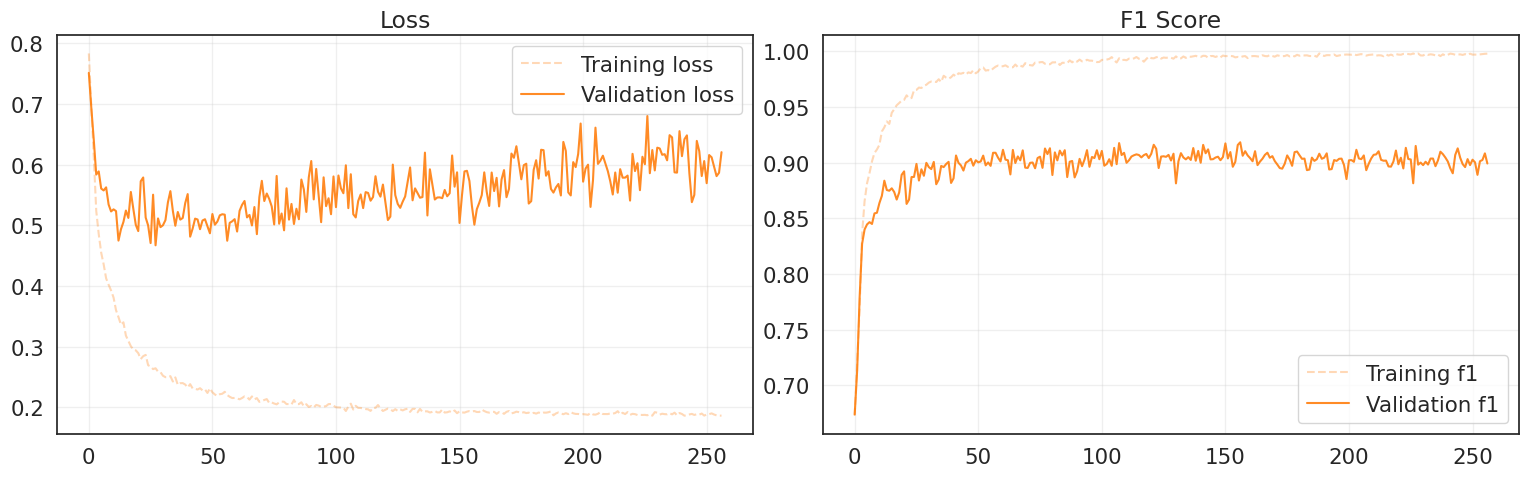

In [50]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9195
Precision over the validation set: 0.9202
Recall over the validation set: 0.9195
F1 score over the validation set: 0.9183


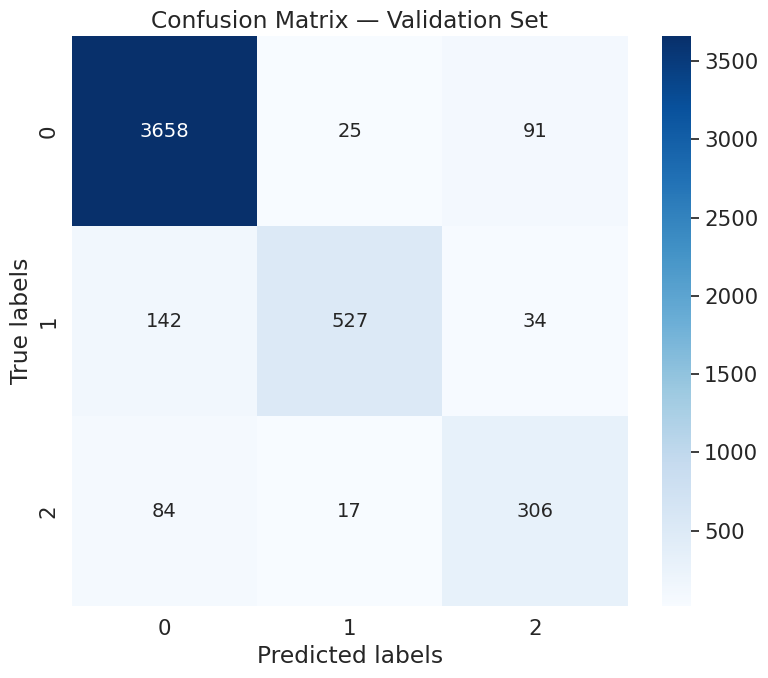

In [51]:
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    # now loader gives (xb, tb, yb)
    for xb, tb, yb in val_loader:
        xb = xb.to(device)
        tb = tb.to(device)
        yb = yb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb, tb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.cpu().numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [52]:
print(test_loader.dataset)
print(val_loader.dataset)

## 🕹️ **Inference**

In [53]:
# Collect probabilities
test_probs = []
with torch.no_grad():
    for xb, tb in test_loader:
        xb = xb.to(device)
        tb = tb.to(device)

        logits = rnn_model(xb, tb)
        probs = F.softmax(logits, dim=1)

        test_probs.append(probs.cpu())

test_probs = torch.cat(test_probs, dim=0)

In [54]:
# Get sequence lengths for each sample
seq_lengths = X_test.groupby('sample_index').size().to_dict()

# Compute number of windows per sample
windows_per_sample = {
    sample_index: ((seq_len - WINDOW_SIZE) // STRIDE) + 1
    for sample_index, seq_len in seq_lengths.items()
}

# Initialize vector of final label predictions
final_preds = []
pointer = 0

# Get label prediction for each sample
for sample_index in X_test['sample_index'].unique():
    w = windows_per_sample[sample_index]
    sample_window_probs = test_probs[pointer:pointer + w]
    pointer += w

    # Get mean probability for each label
    mean_probs = sample_window_probs.mean(dim=0)

    # Select label with max mean probability
    final_label = torch.argmax(mean_probs).item()
    final_preds.append(final_label)

In [55]:
# Map predicted labels to pain levels
label_map = {
    0: "no_pain",
    1: "low_pain",
    2: "high_pain"
}

# Convert numeric predictions to strings
labels = [label_map[p] for p in final_preds]

# Create sample index (zero-padded to 3 digits)
sample_index = [f"{i:03d}" for i in range(len(labels))]

# Build DataFrame
results = pd.DataFrame({
    'sample_index': sample_index,
    'label': labels
})

In [56]:
if LOCAL_RUN:
    # Write results to csv file
    results.to_csv("pirate_pain_test_labels.csv", index=False)

else:
    from google.colab import drive

    # Mount drive
    drive.mount('/content/drive')

    # Write results to csv file
    results.to_csv("/content/drive/MyDrive/pirate_pain_test_labels.csv", index=False)

Mounted at /content/drive
